### Data Scraping

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [140]:
response = requests.get('http://www.worldbirdnames.org/master_ioc-names_xml.xml')
soup = BeautifulSoup(response.text, 'xml')
print(response.status_code)

speciesTree = []
for o in soup.find_all('order'):
    oname = o.find('latin_name').text
    for f in o.find_all('family'):
        fname = f.find('latin_name').text
        for g in f.find_all('genus'):
            gname = g.find('latin_name').text
            gAuthority = g.find('authority').text
            rank = 0
            for s in g.find_all('species'):
                rank +=1
                sname = s.find('latin_name').text
                toApp = [rank, oname, fname, gname, sname, gAuthority, s.find('authority').text, s.find('breeding_regions').text]
                speciesTree.append(toApp)

200


### Cleaning

In [141]:
def cleanNames(nameCol):
    toRet = []
    for n in nameCol:
        #print(n)
        n = n.replace(',', '')
        n = n.replace('& ', '')
        n = n.replace('et al', 'EtAl')
        n = n.strip()
        #print(n)
        toRet.append(n)
    return toRet

In [142]:
df = pd.DataFrame(speciesTree)
df.columns = ['Rank', 'Order', 'Family','Genus','Species','GAuth','SAuth','BreedRegion']

df['OrigG'] = [a.count(')') == 0 for a in df['SAuth']]
df['SAuth'] = df['SAuth'].str.replace( ')', '')
df['SAuth'] = df['SAuth'].str.replace( '(', '')

df['SDate'] = [int(a[-4:]) for a in df['SAuth']]
df['SAuthors'] = [ a[:-4] for a in df['SAuth']]

df['GDate'] = [int(a[-4:]) if a != 'E' else 1816 for a in df['GAuth'] ]
df['GAuthors'] = [a[:-4] if a != 'E' else 'Vieillot' for a in df['GAuth']]

df['SAuthors'] = cleanNames(df['SAuthors'])
df['GAuthors'] = cleanNames(df['GAuthors'])
df['BreedRegion'] = cleanNames(df['BreedRegion'])

df = df.drop(['GAuth','SAuth'], axis = 'columns')
df['DateRank'] = df.groupby('Genus')['SDate'].rank(ascending = True, method = 'min').astype(int)
#df['FullName'] = df['Order'] +' '+ df['Family']+' ' + df['Genus']+'_' + df['Species'].str[:-2]

spg = df.groupby('Genus')['Species'].count()
spg.name = 'SpG'

raw = df.merge(pd.DataFrame(spg), left_on= 'Genus', right_index= True)
#df.to_csv('SpGOrig.csv')

In [3]:
def addToNameDict(wds,MWNameDict):
    if len(wds) == 0:
        return None
    else:
        if wds[0] in MWNameDict:
            toPass = MWNameDict[wds[0]]
           
        else:
            toPass = {}
        MWNameDict[wds[0]] = addToNameDict(wds[1:], toPass)
        return MWNameDict

In [4]:
multiWordNames = ['zu Wied-Neuwied', 'Meyer de Schauensee', 'Barboza du Bocage',
                 'de Sélys-Longchamps', 'Du Bus de Gisignies',
                 'Gurney Sr', 'de Sparre', 'Gurney Jr',
                 'Xántus de Vésey', 'Da Silva Maia', 'de la Llave',
                 'de Filippi', 'Phelps Jr', 'Cardoso da Silva Novaes',
                 'Wetmore Phelps Jr', 'Giraud Jr', 'De Vis',
                 'De Roo', 'La Touche', 'Marshall JT Jr',
                 'de Tarragon', 'Phelps Jr', 'Le Maout',
                 'Raposo do Amaral']

In [5]:
MWND = {}
for n in multiWordNames:
    MWND = addToNameDict(n.lower().split(' '), MWND)

In [175]:
def authorSplit(ent):
    lst=[]
    spt = ent.split(' ')
    i = 0
    while i < len(spt):
        increment = 1
        
        if spt[i].isupper():
            prev = lst.pop()
            lst.append(' '.join([prev, spt[i]]).lower())
            
        elif (len(spt[i:])>1)&(spt[i].lower() in MWND):
            long = longName(spt[i:])
            lst.append(long)
            increment = len(long.split(' '))
                       
        else:
            lst.append(spt[i].lower())
        i+=increment
    return lst

def longName(nList):
    #print(nList)
    toRet = []
    more = MWND.copy()
    
    j = 0
    while more:
        
        toRet.append(nList[j].lower())
        if nList[j].lower() in more:
            more = more[nList[j].lower()]
        else:
            if j == 1:
                return nList[0].lower()
            else:
                print('no')
        
        j+=1
    #print(' '.join(toRet))
    return ' '.join(toRet)

In [176]:
df = raw.copy()
df['SAuthors'] = df['SAuthors'].apply(authorSplit)
df['GAuthors'] = df['GAuthors'].apply(authorSplit)

In [184]:
df.head(10)

Rank             Order         Family      Genus        Species  \
0     1  STRUTHIONIFORMES  Struthionidae   Struthio        camelus   
1     2  STRUTHIONIFORMES  Struthionidae   Struthio  molybdophanes   
2     1        RHEIFORMES        Rheidae       Rhea      americana   
3     2        RHEIFORMES        Rheidae       Rhea        pennata   
4     1    APTERYGIFORMES    Apterygidae    Apteryx      australis   
5     2    APTERYGIFORMES    Apterygidae    Apteryx       mantelli   
6     3    APTERYGIFORMES    Apterygidae    Apteryx           rowi   
7     4    APTERYGIFORMES    Apterygidae    Apteryx         owenii   
8     5    APTERYGIFORMES    Apterygidae    Apteryx        haastii   
9     1    CASUARIIFORMES    Casuariidae  Casuarius      casuarius   

  BreedRegion  OrigG  SDate                                       SAuthors  \
0          AF   True   1758                                     [linnaeus]   
1          AF   True   1883                                    [reichenow]   
2          SA  False   1758                                     [linnaeus]   
3          SA   True   1834                                    [d'orbigny]   
4          AU   True   1813                                         [shaw]   
5          AU   True   1852                                     [bartlett]   
6          AU   True   2003  [tennyson, palma, robertson, worthy, gill bj]   
7          AU   True   1847                                        [gould]   
8          AU   True   1872                                        [potts]   
9          AU  False   1758                                     [linnaeus]   

   GDate    GAuthors  DateRank  SpG  
0   1758  [linnaeus]         1    2  
1   1758  [linnaeus]         2    2  
2   1760   [brisson]         1    2  
3   1760   [brisson]         2    2  
4   1813      [shaw]         1    5  
5   1813      [shaw]         3    5  
6   1813      [shaw]         5    5  
7   1813      [shaw]         2    5  
8   1813      [shaw]         4    5  
9   1760   [brisson]         1    3

In [187]:
def authorCounts(data):
    SpAuths = data['SAuthors']
    GeAuths = pd.Series(data.groupby(['Genus'])['GAuthors'])
    GeAuths.index = GeAuths.map(lambda x: x[0])
    GeAuths = GeAuths.map(lambda x: x[1].iloc[0])
        
    def unlistAuthors(AList):
        ulAuths = []
        for lst in AList:
            for n in lst:
                if not n.islower():
                    print(lst, n)
                ulAuths.append(n)
        ulAuths = pd.Series(ulAuths)
        ulAuths = ulAuths.value_counts()
        
        return ulAuths
    
    SpAuths = unlistAuthors(SpAuths)
    SpAuths.name = 'SpAuthored'
    
    GeAuths = unlistAuthors(GeAuths)
    GeAuths.name = 'GenAuthored'
    
    toRet = pd.concat([GeAuths, SpAuths], axis = 'columns')
    toRet.fillna(0, inplace  = True)
    
    for c in toRet:
        toRet[c] = toRet[c].astype(int)
    
    return toRet

In [ ]:
import pickle


In [313]:
import pickle
try:
    with open('df.pickle', 'rb') as f:
        df = pickle.load(f)
    
except:
    exec(open('./Data.py').read())
    with open('df.pickle', 'rb') as f:
        df = pickle.load(f)

200


In [194]:
cts = authorCounts(df)
#cts.to_csv('authorship.csv')
spg = df.groupby(['SpG'])['Genus'].unique()
spg = spg.apply(len)
spa = cts['SpAuthored'].value_counts()
gpa = cts['GenAuthored'].value_counts()

spg = ('Species', 'Genus', spg, sum([idx*spg[idx] for idx in spg.index]))
spa = ('Species', 'Author', spa, sum([idx*spa[idx] for idx in spa.index]))
gpa = ('Genera', 'Author', gpa, sum([idx*gpa[idx] for idx in gpa.index]))

inspect module

kolmogorov-smirnoff similarity

In [11]:
def plotProp(data):
    dataP = data[2]
    dataP = [idx * data[2][idx]/data[3] for idx in data[2].index]
    plt.scatter(data[2].index, dataP)
    plt.plot([0,max(data[2].index)],[0,max(data[2].index)/data[3]], c = 'r')
    plt.ylim(0,.08)

In [202]:
def plotProp2(data):
    dataP = data[2]
    dataP = [idx * data[2][idx]/data[3] for idx in data[2].index]
    plt.scatter([i / data[3] for i in data[2].index], dataP)
    plt.plot([0,max(data[2].index)/ data[3]],[0,max(data[2].index)/data[3]], c = 'r')
    plt.ylim(0,.08)
    plt.xlim(xmin = -0.001, xmax = 0.01)

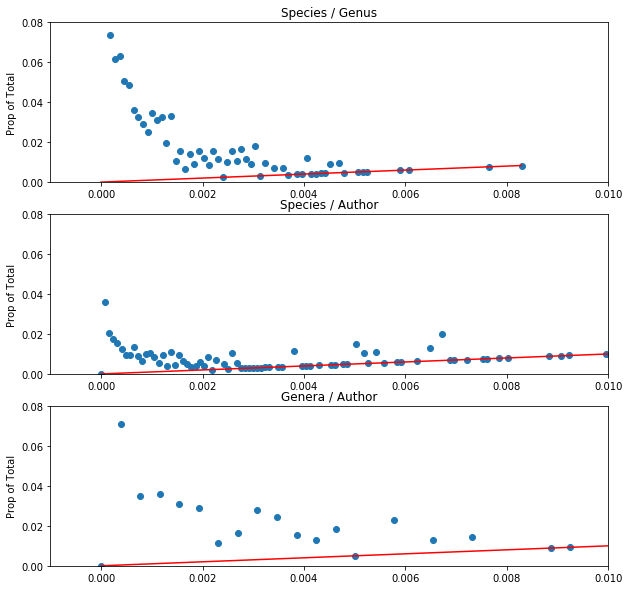

In [203]:
i = 0
plt.figure(figsize = (10,10))
for l in [spg, spa, gpa]:
    i+=1
    plt.subplot(3,1,i)
    plotProp2(l)
    plt.title(str(l[0])+' / '+str(l[1]))
    plt.ylabel('Prop of Total')

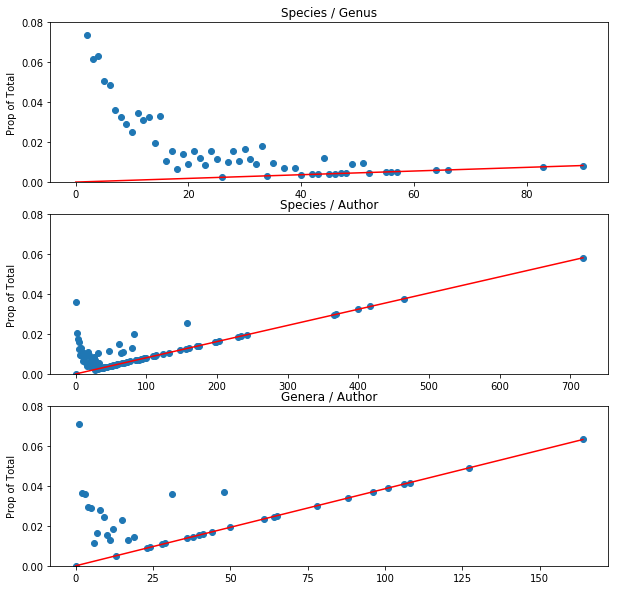

In [425]:
i = 0
plt.figure(figsize = (10,10))
for l in [spg, spa, gpa]:
    i+=1
    plt.subplot(3,1,i)
    plotProp(l)
    plt.title(str(l[0])+' / '+str(l[1]))
    plt.ylabel('Prop of Total')

Text(0.5,1,'sp / A')

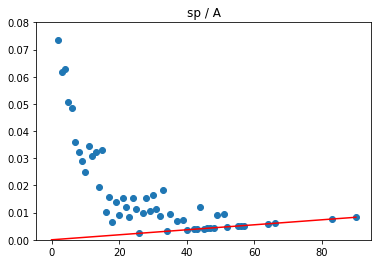

In [418]:
plotProp(spg)
plt.title('sp / A')

In [379]:
tr = []
for l in [spg, spa, gpa]:
    work = l[2].sort_index()
    try:
        work = work.drop(0)
    except:
        pass
    total = sum([idx * work[idx] for idx in work.index])
    tr.append((pd.concat([work.head(6), work.tail(6)], axis = 'rows'), total))

In [12]:
def countPlotter(x,y,log = False):
    xticks = range(1,(int(max(y)/100)+1)*100+1,100)
    yticks = range(1,(int(max(x)/100)+1)*100+1, 25)
    
    if log:
        x = np.log(x)
        y = np.log(y)
        xticks = [np.log(t) for t in  xticks]
        yticks = [np.log(t) for t in yticks]
    plt.scatter(x,y)
    for t in xticks:
        plt.axhline((t), alpha = .1)
    for t in yticks:
        plt.axvline(t, alpha = .1)

def countPlotter2(x,y,rt = False):
    xticks = range(1,(int(max(y)/100)+1)*100+1,100)
    yticks = range(1,(int(max(x)/100)+1)*100+1, 25)
    if log:
        x = x**.25
        y = y**.25
        xticks = [(t)**.25 for t in  xticks]
        yticks = [(t)**.25 for t in yticks]
    plt.scatter(x,y)
    for t in xticks:
        plt.axhline((t), alpha = .1)
    for t in yticks:
        plt.axvline(t, alpha = .1)

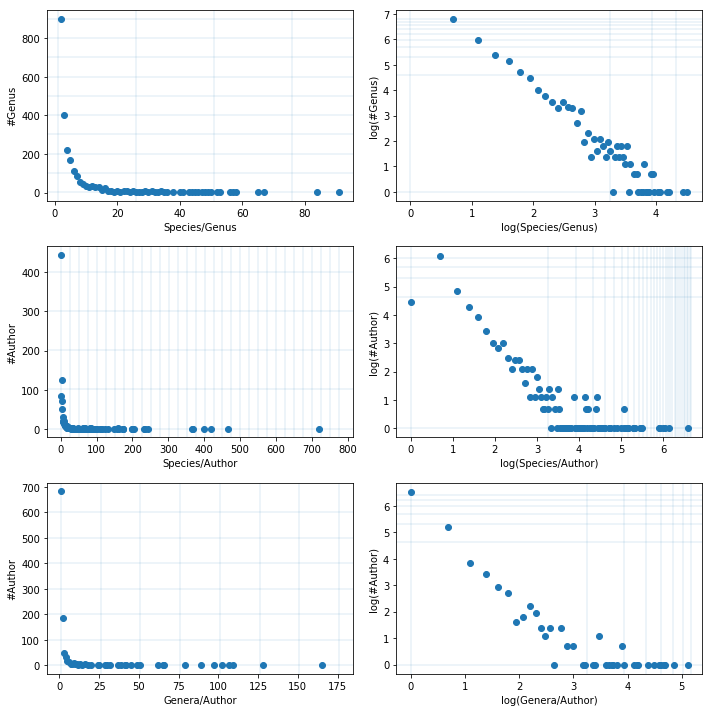

In [326]:
plt.figure(figsize = (10,10))
p = 0
for d in [spg, spa, gpa]:
    for log in [False, True]:
        p += 1
        plt.subplot(3,2,p)
        countPlotter(d[2].index+1, d[2].values, log)
        yl = '#' + d[1]
        xl = d[0] + '/' + d[1]
        ymax = 500
        xmax = 200
        
        if log:
            xl = 'log('+xl+')'
            yl = 'log('+yl+')'
            #plt.xlim(xmax = np.log(xmax))
            #plt.ylim(ymax = np.log(ymax))
        else:
            
            #plt.xlim(xmax = xmax)
            #plt.ylim(ymax = ymax)
            pass
        plt.xlabel(xl)
        plt.ylabel(yl)
plt.tight_layout()

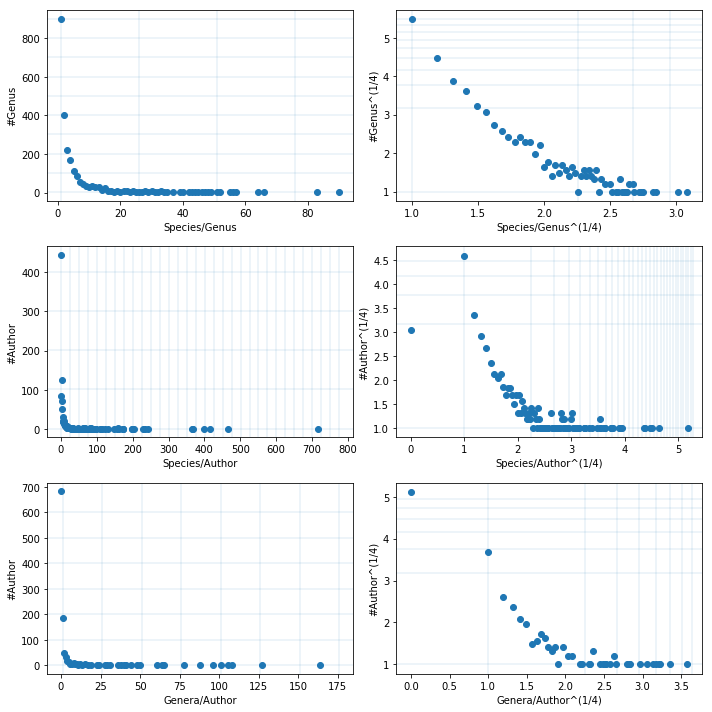

In [19]:
plt.figure(figsize = (10,10))
p = 0
for d in [spg, spa, gpa]:
    for log in [False, True]:
        p += 1
        plt.subplot(3,2,p)
        countPlotter2(d[2].index, d[2].values, log)
        yl = '#' + d[1]
        xl = d[0] + '/' + d[1]
        if log:
            xl = xl+'^(1/4)'
            yl = yl+'^(1/4)'
        plt.xlabel(xl)
        plt.ylabel(yl)
plt.tight_layout()

In [74]:
def plotCDF(tup):
    srt = tup[2].sort_index()
    dataC =[]
    for idx in srt.index:
        if idx == 0:
            dataC.append(0)
        else:         
            toAdd = idx * srt[idx] +dataC[len(dataC)-1] if len(dataC) > 0 else 0
            dataC.append(toAdd)
    if srt.index[0] == 0:
        #print('here')
        plt.plot(srt.index[1:],dataC[1:])
    else:
        plt.plot(srt.index, dataC)
    plt.title(tup[0]+ ' / ' + tup[1]+ ' CDF')
    return dataC

In [55]:
def plotLogCDF(tup):
    srt = tup[2].sort_index()
    dataC =[]
    for idx in srt.index:
        if idx == 0:
            dataC.append(0)
        else:         
            toAdd = idx * srt[idx] +dataC[len(dataC)-1] if len(dataC)>0 else 0
            dataC.append(toAdd)
    plt.plot(np.log(srt.index), np.log(dataC))
    #plt.plot([0,np.log(max(srt.index))],[0,np.log(dataC[max(srt.index)])])
    plt.title(tup[0]+ ' / ' + tup[1]+ ' CDF')
    return np.log(dataC)

In [72]:
def plotPropCDF(tup):
    srt = tup[2].sort_index()
    dataC =[]
    for idx in srt.index:
        if idx == 0:
            dataC.append(0)
        else:         
            toAdd = idx * srt[idx] +dataC[len(dataC)-1] if len(dataC)>0 else 0
            dataC.append(toAdd)
    plt.plot([i / tup[3] for i in srt.index], [d/tup[3] for d in dataC])
    plt.xlim((0,.01))
    plt.title(tup[0]+ ' / ' + tup[1]+ ' CDF')
    return dataC

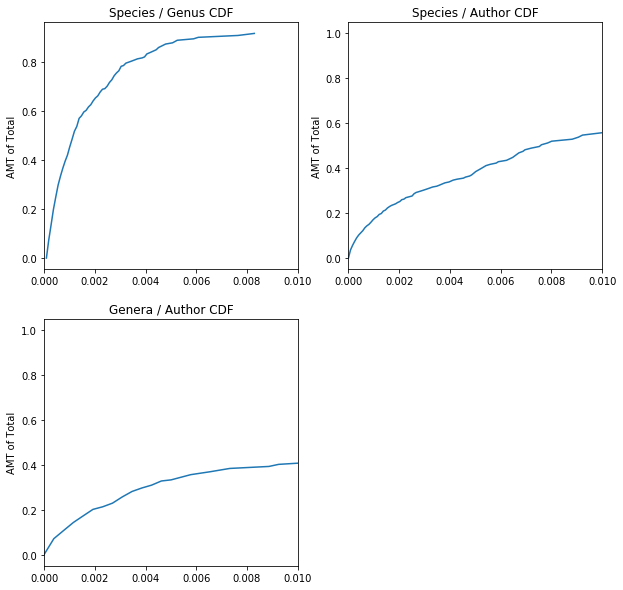

In [73]:
i = 0
ret = []
plt.figure(figsize = (10,10))
for l in [spg, spa, gpa]:
    i+=1
    plt.subplot(2,2,i)
    ret.append(plotPropCDF(l))
    plt.ylabel('AMT of Total')

C:\Users\William\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
C:\Users\William\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


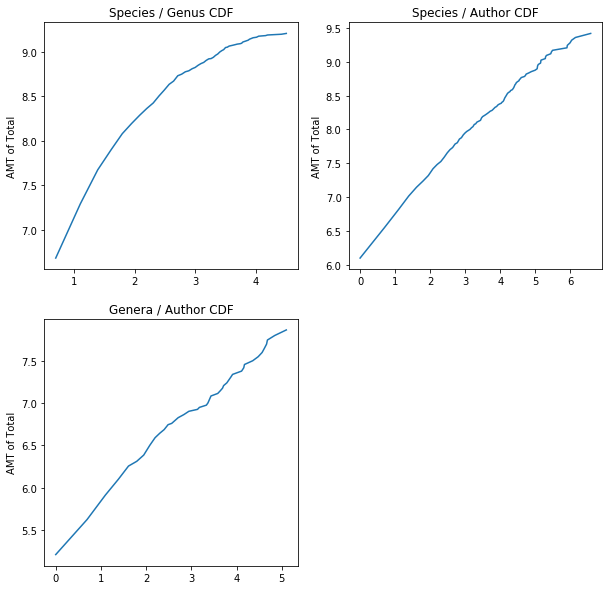

In [57]:
i = 0
ret = []
plt.figure(figsize = (10,10))
for l in [spg, spa, gpa]:
    i+=1
    plt.subplot(2,2,i)
    ret.append(plotLogCDF(l))
    plt.ylabel('AMT of Total')

here
here


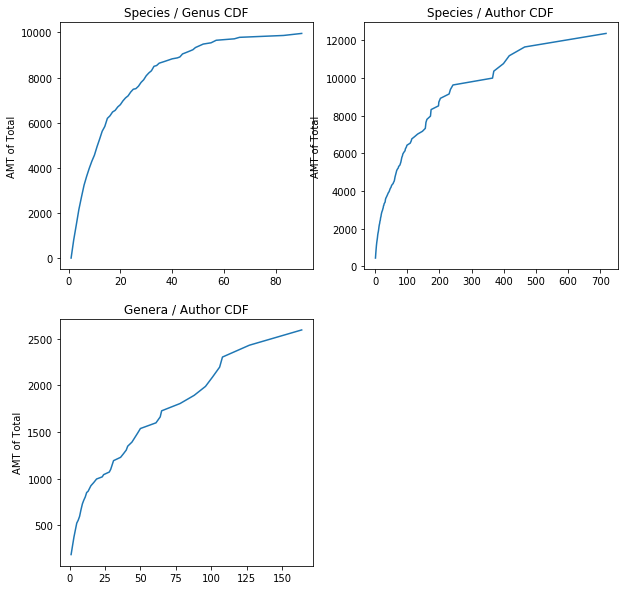

In [75]:
i = 0
plt.figure(figsize = (10,10))
for l in [spg, spa, gpa]:
    i+=1
    plt.subplot(2,2,i)
    plotCDF(l)
    plt.ylabel('AMT of Total')

values = number of authors = Y  
index = species described = X

In [418]:
(.01143)**.5

0.10691117808723276

In [416]:
(((.7*.3)/10)**.5)


0.14491376746189438

In [209]:
def randomizeRank(data):
    dfCollect = []
    for g in data['Genus'].unique():
        work = data[data['Genus'] == g].copy()
        work['Rank'] = np.random.permutation(range(1,len(work)+1))
        dfCollect.append(work)
    return pd.concat(dfCollect, axis = 'rows')

In [210]:
def alphaRank(data):
    dfCollect = []
    for g in data['Genus'].unique():
        work = data[data['Genus'] == g].copy()
        work = work.sort_values('Species')
        work['Rank'] = range(1,len(work)+1)
        dfCollect.append(work)
    return pd.concat(dfCollect, axis = 'rows')

In [211]:
%%time
dfp = df.drop(['Order', 'Family','BreedRegion','OrigG','GDate','GAuthors', 'SAuthors'], axis = 'columns')
randomR = randomizeRank(dfp)
alphaR = alphaRank(dfp)

Wall time: 12.2 s


In [299]:
realtabs = makeSpeciesRankDateTablesAll(dfp)
randomtabs = makeSpeciesRankDateTablesAll(randomR)
alphatabs = makeSpeciesRankDateTablesAll(alphaR)

In [216]:
realtabs

{1: {1: [902]},
 2: {1: [296, 104], 2: [120, 280]},
 3: {1: [127, 49, 47], 2: [56, 88, 79], 3: [57, 83, 83]},
 4: {1: [81, 44, 27, 19],
  2: [32, 49, 42, 48],
  3: [37, 34, 55, 45],
  4: [43, 35, 47, 46]},
 5: {1: [36, 26, 25, 13, 10],
  2: [24, 24, 17, 22, 23],
  3: [22, 16, 20, 21, 31],
  4: [27, 23, 22, 22, 16],
  5: [13, 19, 20, 36, 22]},
 6: {1: [25, 16, 18, 13, 4, 12],
  2: [14, 14, 18, 18, 13, 11],
  3: [21, 11, 15, 7, 16, 18],
  4: [13, 15, 11, 19, 16, 14],
  5: [17, 11, 15, 17, 20, 8],
  6: [14, 16, 11, 14, 16, 17]},
 7: {1: [19, 6, 8, 5, 5, 5, 8],
  2: [6, 7, 9, 6, 8, 7, 13],
  3: [6, 8, 8, 11, 11, 7, 5],
  4: [6, 9, 6, 6, 9, 9, 11],
  5: [13, 9, 4, 8, 6, 10, 6],
  6: [12, 8, 7, 10, 8, 3, 8],
  7: [7, 4, 10, 8, 9, 14, 4]},
 8: {1: [14, 7, 5, 5, 5, 4, 3, 1],
  2: [8, 5, 7, 4, 9, 7, 2, 2],
  3: [4, 5, 9, 3, 3, 5, 7, 8],
  4: [8, 2, 2, 8, 7, 4, 6, 7],
  5: [3, 2, 5, 6, 7, 6, 6, 9],
  6: [7, 7, 5, 5, 6, 3, 6, 5],
  7: [6, 4, 7, 6, 3, 7, 5, 6],
  8: [6, 7, 4, 5, 4, 4, 8, 6]},
 9: 

In [256]:
def makeSpeciesRankDateTablesAll(data):
    
    data = pd.DataFrame(data.groupby(['SpG','Rank', 'DateRank',])['Species'].count())
    
    tables = {}
    
    currentSPG = 0
    currentRank = 0
    prevDR = 0
    full = True
    
    for idx in data.index:
        
        # index in the format (species/genus, Rank, Date Rank)
        spg = idx[0]
        rank = idx[1]
        dRank = idx[2]
        sp = data.loc[idx, 'Species']
                    
        # If the s/G changes, create new list, reset counter variables
        if spg != currentSPG:
            if not full:
                while len(tables[currentSPG][currentRank]) < currentSPG:
                    tables[currentSPG][currentRank].append(0)
                    
            tables[spg] = {}
            currentSPG = spg
            tables[spg][rank] = []
            currentRank = 1
            prevDR = 0
            full = False
        
        # If rank changes, create new list, reset dateRank counter
        if rank != currentRank:
            if not full:
                while len(tables[currentSPG][currentRank]) < currentSPG:
                    tables[currentSPG][currentRank].append(0)
                    
            tables[spg][rank] = []
            currentRank = rank
            prevDR = 0
        
        # Check to see that current date rank is only one greater than previous
        # DateRank, if not, one was skipped, in which case zeros need to be added
        if prevDR +1 != dRank:
            for i in range(dRank-prevDR-1):
                tables[spg][rank].append(0)
        
        #append number of species
        tables[spg][rank].append(sp)
        full = len(tables[spg][rank]) == currentSPG
        prevDR = dRank
    if not full:
        while len(tables[currentSPG][currentRank])<currentSPG:
            tables[currentSPG][currentRank].append(0)
    return tables    

In [427]:
%%timeit
realtabs = makeSpeciesRankDateTablesAll(dfp)
randomtabs = makeSpeciesRankDateTablesAll(randomR)
alphatabs = makeSpeciesRankDateTablesAll(alphaR)

2.59 s ± 197 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [426]:
%%timeit
realtabs = makeSpeciesRankDateTables(dfp)
randomtabs = makeSpeciesRankDateTables(randomR)
alphatabs = makeSpeciesRankDateTables(alphaR)

3.01 s ± 472 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [436]:
test = {1 : ["a", 'b','c'], 2:[True, False]}
print(test)
toChange = test[1]
toChange.pop()
print(test)
print()

test = {1 : ["a", 'b','c'], 2:[True, False]}
print(test)
def topop(dct, key):
    toChange = dct[key]
    toChange.pop()
    #print(dct)
    return toChange
    
test[1] = topop(test, 1)

print(test)
print()

test = {1 : ["a", 'b','c'], 2:[True, False]}
print(test)
def topop2(key):
    toChange = test[key]
    #print(toChange)
    toChange.pop()
    #print(dct)

topop2(1)
print(test)


{1: ['a', 'b', 'c'], 2: [True, False]}
{1: ['a', 'b'], 2: [True, False]}

{1: ['a', 'b', 'c'], 2: [True, False]}
{1: ['a', 'b'], 2: [True, False]}

{1: ['a', 'b', 'c'], 2: [True, False]}
{1: ['a', 'b'], 2: [True, False]}


In [422]:
def makeSpeciesRankDateTables(data):
    
    data = pd.DataFrame(data.groupby(['SpG','Rank', 'DateRank',])['Species'].count())

    # tables will have the structure:
    # {SpG: {Rank: [<list>]}}
    # The [<list>] will be the number of species that are in a genera with 
    # that particular SpG, are of that Rank, and are of the DateRank
    # corresponding to the index location of the list plus 1
    tables = {}
    
    currentSPG = 0
    currentRank = 0
    prevDR = 0
    
    for idx in data.index:
        
        # MultiIndex in the format: (SpG, Rank, Date Rank)
        spg = idx[0]
        rank = idx[1]
        dRank = idx[2]
        sp = data.loc[idx, 'Species']
                    
        # If the SpG changes, create new list, reset counter variables
        if spg != currentSPG:                 
            tables[spg] = {}
            currentSPG = spg
            tables[spg][rank] = []
            currentRank = 1
            prevDR = 0
            
        
        # If rank changes, create new list, reset dateRank counter
        if rank != currentRank:               
            tables[spg][rank] = []
            currentRank = rank
            prevDR = 0
        
        # Check to see that current date rank is only one greater than previous
        # DateRank, if not, one was skipped, in which case zeros need to be added
        if prevDR +1 != dRank:
            for i in range(dRank-prevDR-1):
                tables[spg][rank].append(0)
        
        # append number of species
        tables[spg][rank].append(sp)
        prevDR = dRank
    
    # Check to ensure each list is properly filled
    for spg in tables:
        for rank in tables[spg]:
            while len(tables[spg][rank]) < spg:
                tables[spg][rank].append(0)
                
    return tables


In [149]:
def speciesRankDateHeat(tables, title):
    locs = {1:(1,1),2:(1,2),3:(1,4),4:(1,7),5:(1,11),6:(1,16),7:(7,15),8:(6,1),9:(15,1),10:(14,12)}
    plt.figure(figsize = (20,20))
    
    i = 0
    for k in tables:
        i+=1

        temp = pd.DataFrame(tables[k])
        temp.index = range(1,len(temp)+1)
        
        for c in temp:
            temp[c] = [e/temp[c].sum()/(1/len(temp)) for e in temp[c]]
            temp[c] = [e/2.6 for e in temp[c]]
            
        where = locs[i]
        plt.subplot2grid((23,21),(where[0]-1, where[1]-1), colspan = i, rowspan = i)
        sns.heatmap(temp, annot = True, center = .5,
                    cmap = 'coolwarm', square = True, cbar = False)
    
    plt.subplot2grid((23,21),(5,8), colspan = 5, rowspan = 5)
    plt.axis('equal')
    plt.axis('off')
    
    plt.text(-0.05,-0.01,'species Rank', rotation = 'vertical', fontsize = 28)#, horizontalalignment = 'right')
    plt.text(-0.036,-0.08,'Date Rank', rotation = 'horizontal', fontsize = 24)#, horizontalalignment = 'left')
    plt.text(0.009,0.00,'Proportion\n of\n species\n'+title, fontsize = 30, horizontalalignment = 'center')

In [219]:
t = [0,2]
t[0] +=1
t

[1, 2]

In [279]:
def speciesRankDateAgg(tables):
    agg = {}

    for spg in tables:
        if spg == 1:
            pass
        else:
            
            temp = pd.DataFrame(tables[spg])
            temp.index = range(1,len(temp)+1)

            obs = 0
            for c in temp:
                obs += temp[c].sum()

            genera = obs / spg

            # expected  = genera * 1/spg for all spg
            # Actual = sum for each location.

            for dRank in temp:
                if dRank not in agg.keys():
                    agg[dRank] = {}
                for rank in temp[dRank].index:
                    if rank not in agg[dRank].keys():
                        agg[dRank][rank] = [0, 0, 0 ]
                    agg[dRank][rank][1] += genera * (1/spg)
                    agg[dRank][rank][0] += temp.loc[rank,dRank] 
                    agg[dRank][rank][2] += genera

    return agg

In [301]:
realAgg = speciesRankDateHeatAgg(realtabs)
ranAgg = speciesRankDateHeatAgg(randomtabs)
alphaAgg = speciesRankDateHeatAgg(alphatabs)

In [411]:
pd.DataFrame(realAgg)

1                                  2   \
1   [661, 389.04674136368095, 1410.0]  [304, 389.04674136368095, 1410.0]   
2   [282, 389.04674136368095, 1410.0]  [492, 389.04674136368095, 1410.0]   
3     [159, 189.046741363681, 1010.0]    [195, 189.046741363681, 1010.0]   
4     [79, 114.71340803034771, 787.0]   [118, 114.71340803034771, 787.0]   
5      [45, 71.96340803034771, 616.0]     [65, 71.96340803034771, 616.0]   
6      [39, 49.96340803034771, 506.0]     [51, 49.96340803034771, 506.0]   
7      [24, 35.29674136368104, 418.0]     [34, 35.29674136368104, 418.0]   
8      [18, 27.29674136368103, 362.0]     [25, 27.29674136368103, 362.0]   
9     [18, 21.796741363681026, 318.0]    [23, 21.796741363681026, 318.0]   
10    [11, 17.907852474792136, 283.0]    [12, 17.907852474792136, 283.0]   
11     [6, 15.207852474792134, 256.0]    [15, 15.207852474792134, 256.0]   
12     [8, 12.116943383883044, 222.0]    [10, 12.116943383883044, 222.0]   
13      [7, 9.783610050549713, 194.0]     [10, 9.783610050549713, 194.0]   
14      [9, 7.706686973626635, 167.0]      [5, 7.706686973626635, 167.0]   
15      [5, 6.635258402198064, 152.0]      [5, 6.635258402198064, 152.0]   
16      [2, 5.035258402198064, 128.0]      [1, 5.035258402198064, 128.0]   
17      [4, 4.597758402198063, 121.0]      [7, 4.597758402198063, 121.0]   
18      [5, 4.009523108080416, 111.0]      [5, 4.009523108080416, 111.0]   
19      [6, 3.787300885858194, 107.0]      [5, 3.787300885858194, 107.0]   
20      [5, 3.3662482542792467, 99.0]      [3, 3.3662482542792467, 99.0]   
21      [2, 3.1162482542792467, 94.0]      [2, 3.1162482542792467, 94.0]   
22      [0, 2.7352958733268657, 86.0]      [3, 2.7352958733268657, 86.0]   
23      [1, 2.4625686005995933, 80.0]      [2, 2.4625686005995933, 80.0]   
24      [3, 2.2886555571213325, 76.0]      [2, 2.2886555571213325, 76.0]   
25       [0, 1.996988890454665, 69.0]       [0, 1.996988890454665, 69.0]   
26      [1, 1.7969888904546654, 64.0]      [1, 1.7969888904546654, 64.0]   
27      [1, 1.7585273519931266, 63.0]      [2, 1.7585273519931266, 63.0]   
28      [0, 1.6103792038449787, 59.0]      [1, 1.6103792038449787, 59.0]   
29      [1, 1.3960934895592647, 53.0]      [0, 1.3960934895592647, 53.0]   
30      [3, 1.2581624550765063, 49.0]      [1, 1.2581624550765063, 49.0]   
..                                ...                                ...   
61       [0, 0.0539358190337106, 4.0]       [0, 0.0539358190337106, 4.0]   
62       [0, 0.0539358190337106, 4.0]       [0, 0.0539358190337106, 4.0]   
63       [0, 0.0539358190337106, 4.0]       [0, 0.0539358190337106, 4.0]   
64       [0, 0.0539358190337106, 4.0]       [1, 0.0539358190337106, 4.0]   
65       [0, 0.0383108190337106, 3.0]       [0, 0.0383108190337106, 3.0]   
66       [0, 0.0383108190337106, 3.0]       [0, 0.0383108190337106, 3.0]   
67     [0, 0.023159303882195448, 2.0]     [0, 0.023159303882195448, 2.0]   
68     [0, 0.023159303882195448, 2.0]     [0, 0.023159303882195448, 2.0]   
69     [0, 0.023159303882195448, 2.0]     [0, 0.023159303882195448, 2.0]   
70     [0, 0.023159303882195448, 2.0]     [0, 0.023159303882195448, 2.0]   
71     [0, 0.023159303882195448, 2.0]     [0, 0.023159303882195448, 2.0]   
72     [0, 0.023159303882195448, 2.0]     [0, 0.023159303882195448, 2.0]   
73     [0, 0.023159303882195448, 2.0]     [0, 0.023159303882195448, 2.0]   
74     [1, 0.023159303882195448, 2.0]     [0, 0.023159303882195448, 2.0]   
75     [0, 0.023159303882195448, 2.0]     [0, 0.023159303882195448, 2.0]   
76     [0, 0.023159303882195448, 2.0]     [0, 0.023159303882195448, 2.0]   
77     [0, 0.023159303882195448, 2.0]     [0, 0.023159303882195448, 2.0]   
78     [0, 0.023159303882195448, 2.0]     [0, 0.023159303882195448, 2.0]   
79     [0, 0.023159303882195448, 2.0]     [0, 0.023159303882195448, 2.0]   
80     [0, 0.023159303882195448, 2.0]     [0, 0.023159303882195448, 2.0]   
81     [0, 0.023159303882195448, 2.0]     [0, 0.023159303882195448, 2.0]   
82     

In [281]:
pd.DataFrame(a)

1                                  2   \
1   [661, 389.04674136368095, 1410.0]  [304, 389.04674136368095, 1410.0]   
2   [282, 389.04674136368095, 1410.0]  [492, 389.04674136368095, 1410.0]   
3     [159, 189.046741363681, 1010.0]    [195, 189.046741363681, 1010.0]   
4     [79, 114.71340803034771, 787.0]   [118, 114.71340803034771, 787.0]   
5      [45, 71.96340803034771, 616.0]     [65, 71.96340803034771, 616.0]   
6      [39, 49.96340803034771, 506.0]     [51, 49.96340803034771, 506.0]   
7      [24, 35.29674136368104, 418.0]     [34, 35.29674136368104, 418.0]   
8      [18, 27.29674136368103, 362.0]     [25, 27.29674136368103, 362.0]   
9     [18, 21.796741363681026, 318.0]    [23, 21.796741363681026, 318.0]   
10    [11, 17.907852474792136, 283.0]    [12, 17.907852474792136, 283.0]   
11     [6, 15.207852474792134, 256.0]    [15, 15.207852474792134, 256.0]   
12     [8, 12.116943383883044, 222.0]    [10, 12.116943383883044, 222.0]   
13      [7, 9.783610050549713, 194.0]     [10, 9.783610050549713, 194.0]   
14      [9, 7.706686973626635, 167.0]      [5, 7.706686973626635, 167.0]   
15      [5, 6.635258402198064, 152.0]      [5, 6.635258402198064, 152.0]   
16      [2, 5.035258402198064, 128.0]      [1, 5.035258402198064, 128.0]   
17      [4, 4.597758402198063, 121.0]      [7, 4.597758402198063, 121.0]   
18      [5, 4.009523108080416, 111.0]      [5, 4.009523108080416, 111.0]   
19      [6, 3.787300885858194, 107.0]      [5, 3.787300885858194, 107.0]   
20      [5, 3.3662482542792467, 99.0]      [3, 3.3662482542792467, 99.0]   
21      [2, 3.1162482542792467, 94.0]      [2, 3.1162482542792467, 94.0]   
22      [0, 2.7352958733268657, 86.0]      [3, 2.7352958733268657, 86.0]   
23      [1, 2.4625686005995933, 80.0]      [2, 2.4625686005995933, 80.0]   
24      [3, 2.2886555571213325, 76.0]      [2, 2.2886555571213325, 76.0]   
25       [0, 1.996988890454665, 69.0]       [0, 1.996988890454665, 69.0]   
26      [1, 1.7969888904546654, 64.0]      [1, 1.7969888904546654, 64.0]   
27      [1, 1.7585273519931266, 63.0]      [2, 1.7585273519931266, 63.0]   
28      [0, 1.6103792038449787, 59.0]      [1, 1.6103792038449787, 59.0]   
29      [1, 1.3960934895592647, 53.0]      [0, 1.3960934895592647, 53.0]   
30      [3, 1.2581624550765063, 49.0]      [1, 1.2581624550765063, 49.0]   
..                                ...                                ...   
61       [0, 0.0539358190337106, 4.0]       [0, 0.0539358190337106, 4.0]   
62       [0, 0.0539358190337106, 4.0]       [0, 0.0539358190337106, 4.0]   
63       [0, 0.0539358190337106, 4.0]       [0, 0.0539358190337106, 4.0]   
64       [0, 0.0539358190337106, 4.0]       [1, 0.0539358190337106, 4.0]   
65       [0, 0.0383108190337106, 3.0]       [0, 0.0383108190337106, 3.0]   
66       [0, 0.0383108190337106, 3.0]       [0, 0.0383108190337106, 3.0]   
67     [0, 0.023159303882195448, 2.0]     [0, 0.023159303882195448, 2.0]   
68     [0, 0.023159303882195448, 2.0]     [0, 0.023159303882195448, 2.0]   
69     [0, 0.023159303882195448, 2.0]     [0, 0.023159303882195448, 2.0]   
70     [0, 0.023159303882195448, 2.0]     [0, 0.023159303882195448, 2.0]   
71     [0, 0.023159303882195448, 2.0]     [0, 0.023159303882195448, 2.0]   
72     [0, 0.023159303882195448, 2.0]     [0, 0.023159303882195448, 2.0]   
73     [0, 0.023159303882195448, 2.0]     [0, 0.023159303882195448, 2.0]   
74     [1, 0.023159303882195448, 2.0]     [0, 0.023159303882195448, 2.0]   
75     [0, 0.023159303882195448, 2.0]     [0, 0.023159303882195448, 2.0]   
76     [0, 0.023159303882195448, 2.0]     [0, 0.023159303882195448, 2.0]   
77     [0, 0.023159303882195448, 2.0]     [0, 0.023159303882195448, 2.0]   
78     [0, 0.023159303882195448, 2.0]     [0, 0.023159303882195448, 2.0]   
79     [0, 0.023159303882195448, 2.0]     [0, 0.023159303882195448, 2.0]   
80     [0, 0.023159303882195448, 2.0]     [0, 0.023159303882195448, 2.0]   
81     [0, 0.023159303882195448, 2.0]     [0, 0.023159303882195448, 2.0]   
82     

In [310]:
true = 661
expect = 389.0467414
n = 1410
phat = true/n
p0 = expect / n


sq = ((phat*(1-phat))/n)**.5
tenth = 3.8
one = 2.325
tenthR = ((phat - (tenth/2)*sq)*n, (phat + (tenth/2)*sq)*n)
oneR = ((phat - (one/2)*sq)*n, (phat + (one/2)*sq)*n)
print(tenthR, oneR, p0*n)

(625.3970746878836, 696.6029253121164) (639.2166312235078, 682.7833687764922) 0.27591967475177304


observed - theorhetical over sqrt theorietical * 1-theoretical / n

In [285]:
import scipy.stats as stats
stats.norm.cdf(-1.64)

0.050502583474103711

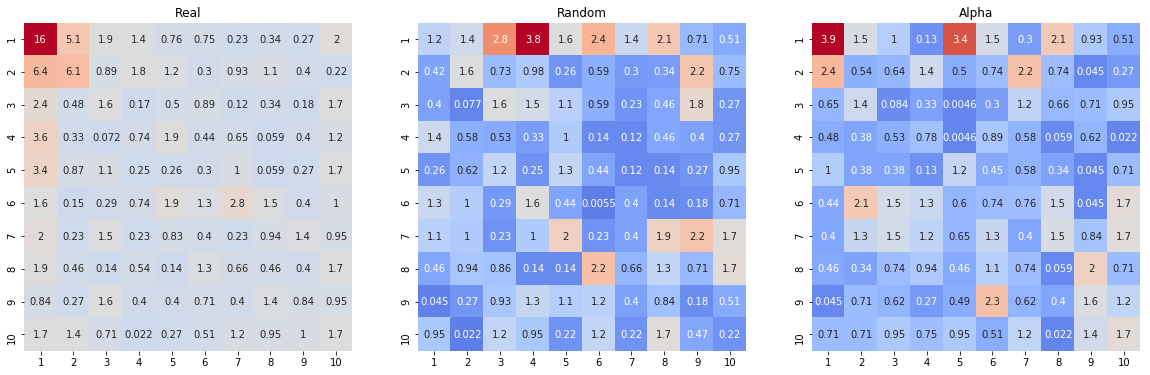

In [303]:
plt.figure(figsize = (20,20))
i = 0
for tab, name in zip([realAgg, ranAgg, alphaAgg], ['Real','Random','Alpha']):
    i+=1
    test = pd.DataFrame(tab)
    for c in test:
        test[c] = test[c].apply(lambda x: abs(((x[0]/x[2] - x[1]/x[2])/ (((x[1]/x[2])*(1-(x[1]/x[2])))/x[2])**.5)))
    test = test[list(range(1,11))]
    test = test.loc[1:10,:]
    plt.subplot(1,3,i)
    sns.heatmap(test, annot = True, center = 1.64,
                        cmap = 'coolwarm', square = True, cbar = False)
    plt.title(name)

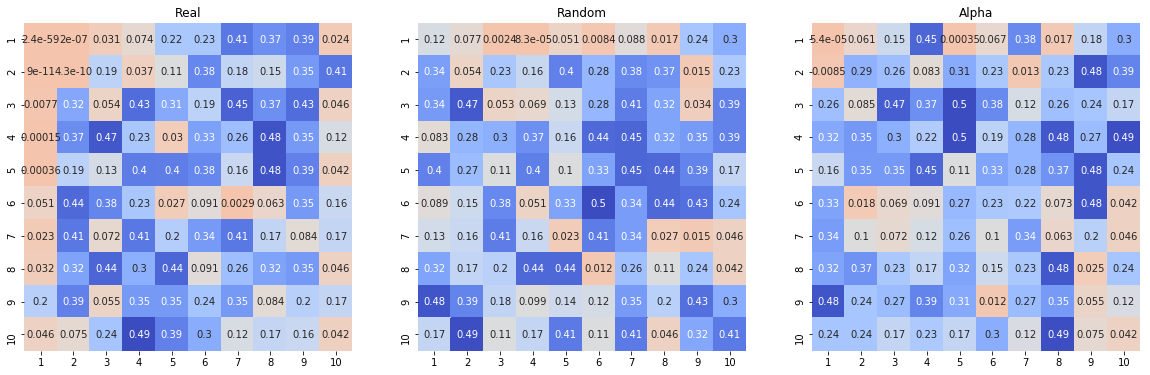

In [306]:
plt.figure(figsize = (20,20))
i = 0
for tab, name in zip([realAgg, ranAgg, alphaAgg], ['Real','Random','Alpha']):
    i+=1
    test = pd.DataFrame(tab)
    for c in test:
        test[c] = test[c].apply(lambda x: stats.norm.cdf(-abs((x[0]/x[2] - x[1]/x[2])/ (((x[1]/x[2])*(1-(x[1]/x[2])))/x[2])**.5)))
    test.head()
    test = test[list(range(1,11))]
    test = test.loc[1:10,:]
    plt.subplot(1,3,i)
    sns.heatmap(test, annot = True, center = 0.1,
                        cmap = 'coolwarm_r', square = True, cbar = False)
    plt.title(name)

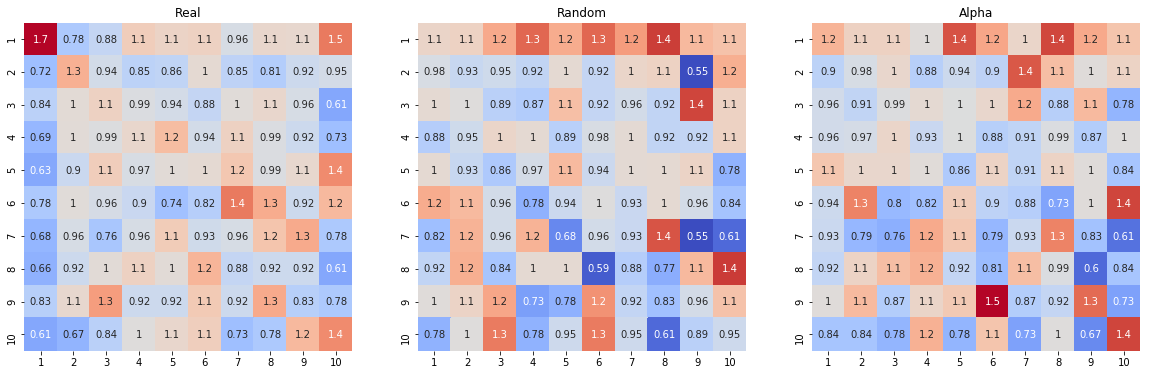

In [307]:
plt.figure(figsize = (20,20))
i = 0
for tab, name in zip([realAgg, ranAgg, alphaAgg], ['Real','Random','Alpha']):
    i+=1
    test = pd.DataFrame(tab)
    for c in test:
        test[c] = test[c].apply(lambda x: x[0]/x[1])
    test.head()
    test = test[list(range(1,11))]
    test = test.loc[1:10,:]
    plt.subplot(1,3,i)
    sns.heatmap(test, annot = True, center = 1,
                        cmap = 'coolwarm', square = True, cbar = False)
    plt.title(name)

In [86]:
import seaborn as sns
from matplotlib import gridspec
import matplotlib.colors as colors

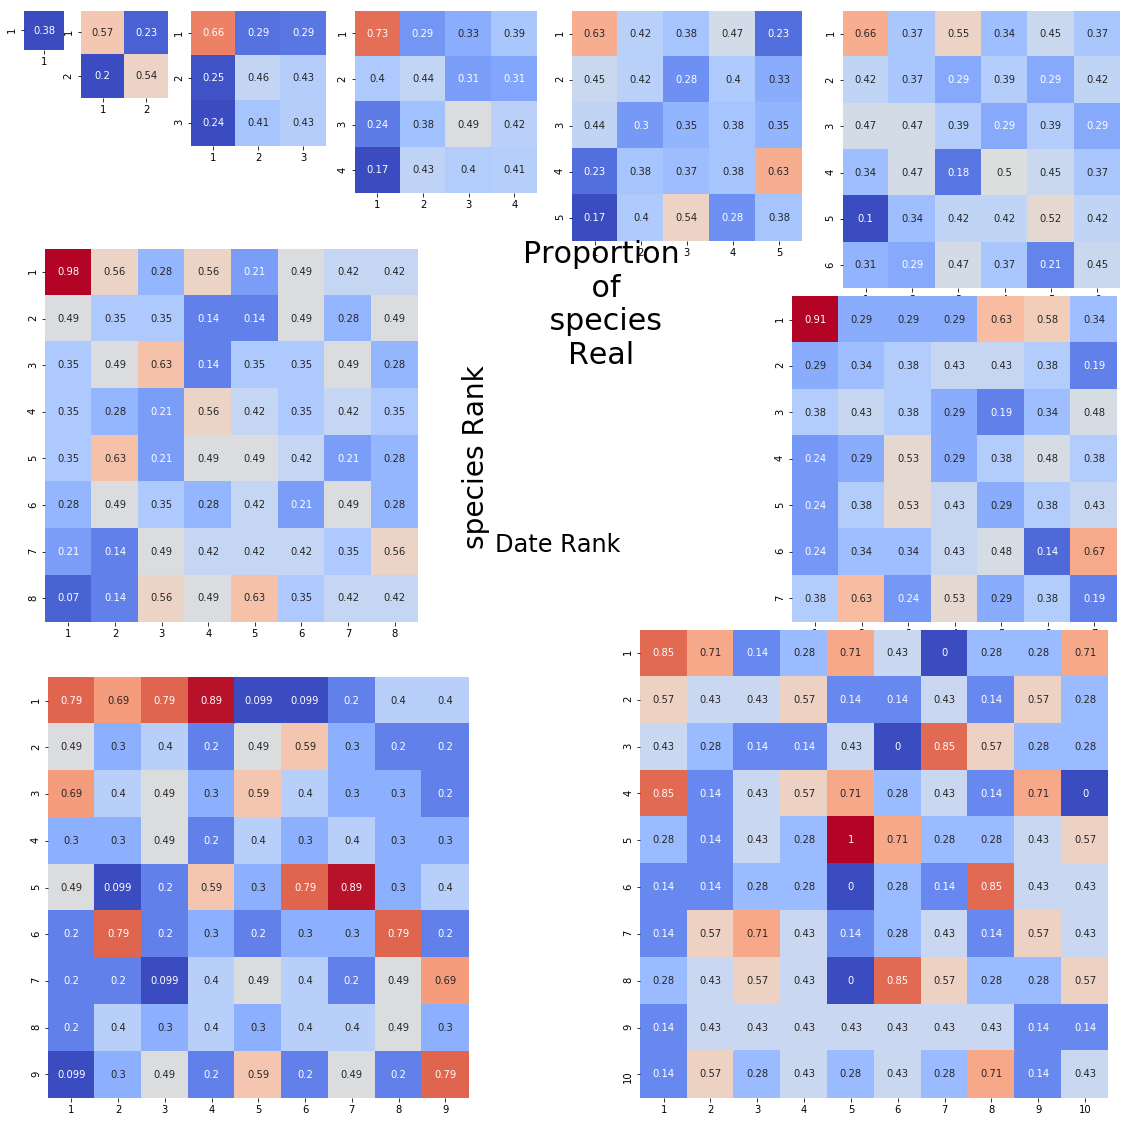

In [152]:
speciesRankDateHeat(realtabs, 'Real')

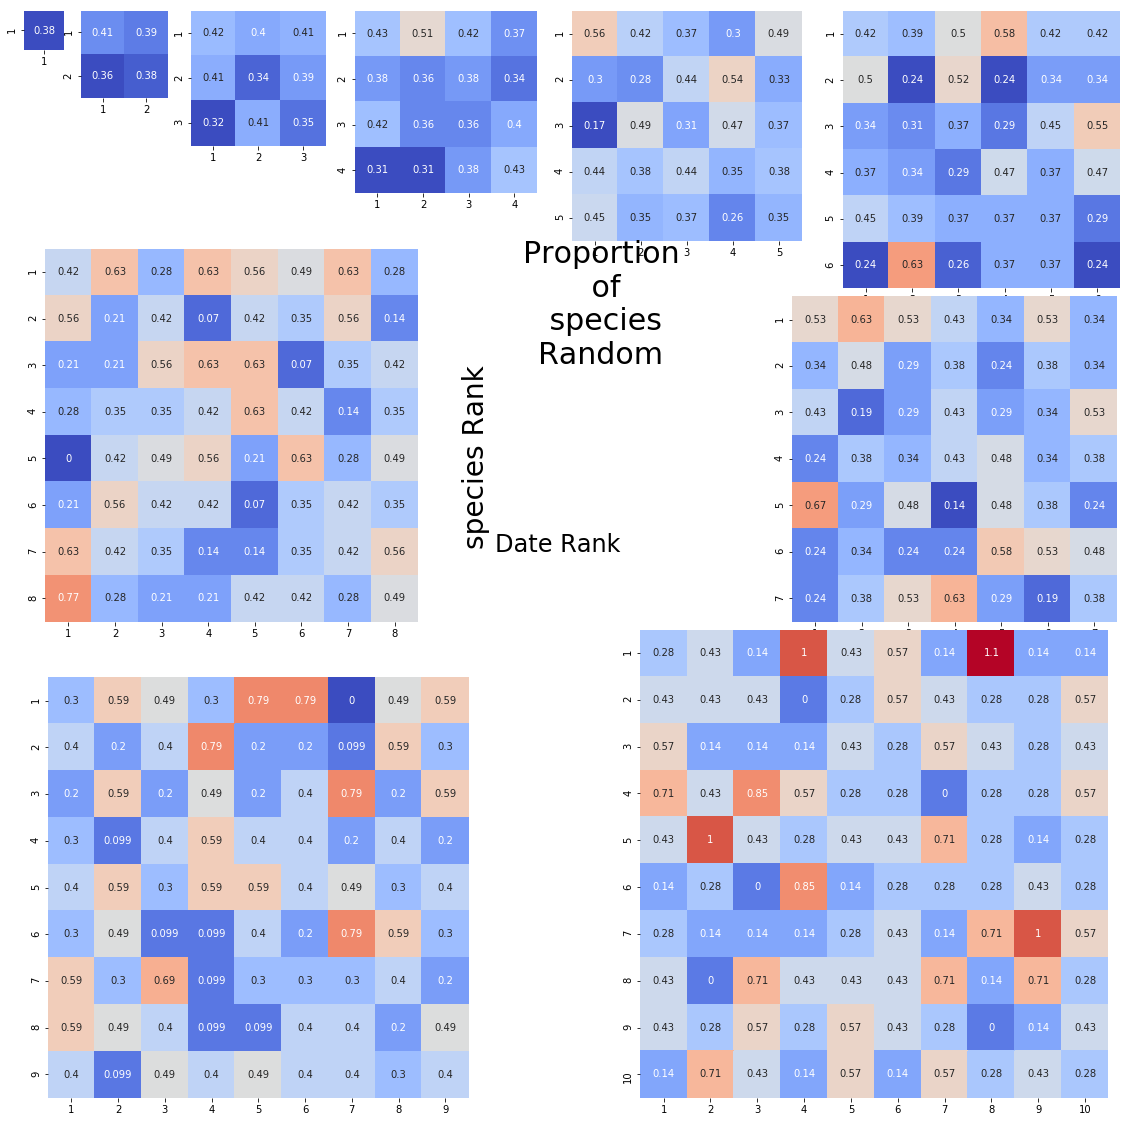

In [151]:
speciesRankDateHeat(randomtabs, 'Random')

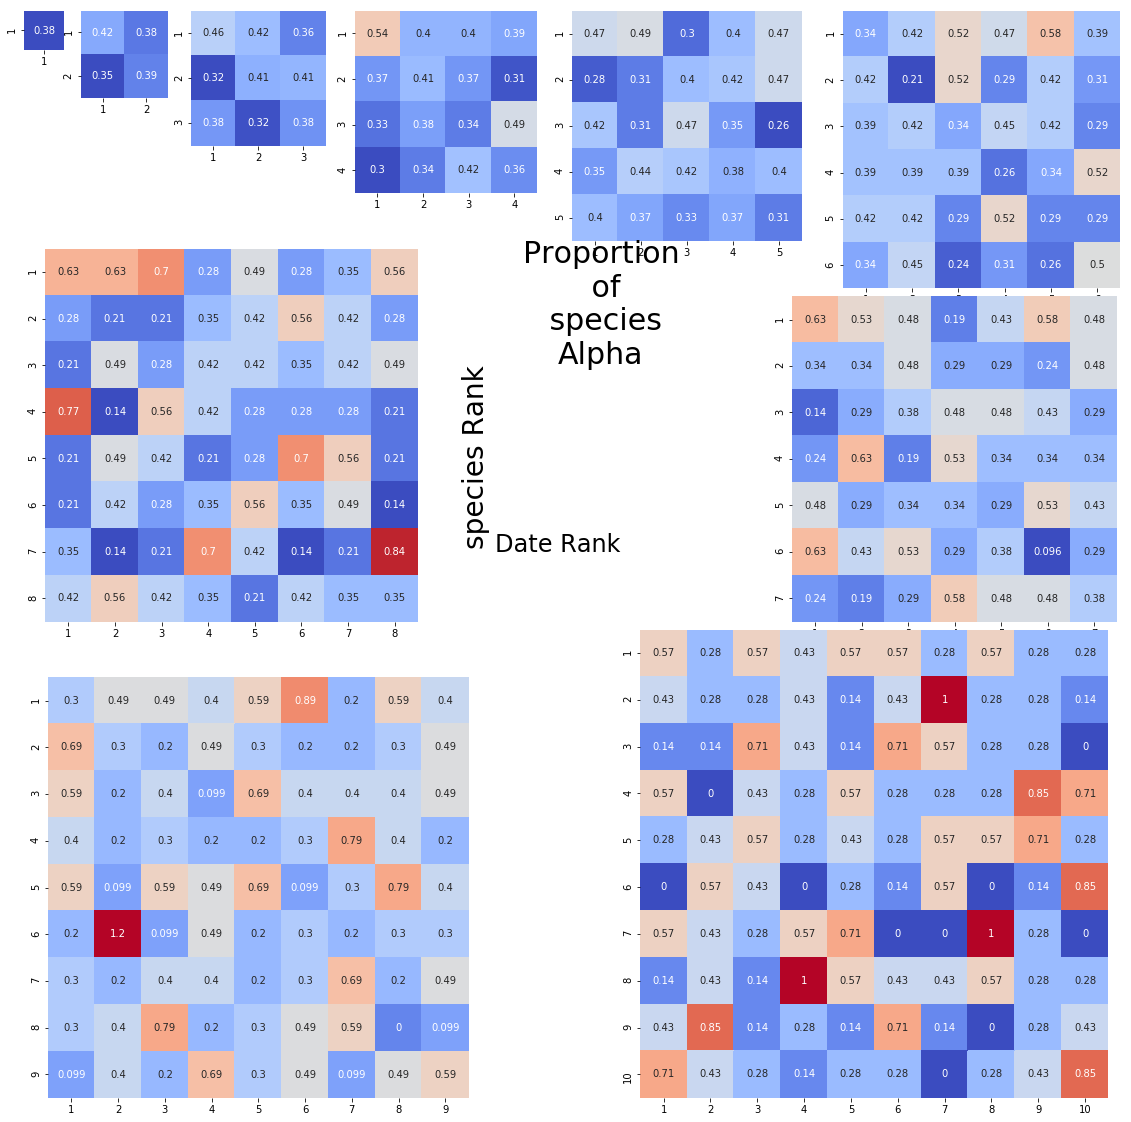

In [150]:
speciesRankDateHeat(alphatabs, 'Alpha')

In [101]:
data = df

counts = df.groupby(['Rank'])['Species'].count()
data = pd.DataFrame(data.groupby(['Rank','DateRank'])['Species'].count())
data['Rank'] = data.index.map(lambda x: x[0])
data['DateRank'] = data.index.map(lambda x: x[1])
data.index = range(len(data))
data['Count'] = [counts[r] for r in data['Rank']]

data = data[data['Rank'] <=10]
data = data[data['DateRank'] <=10]
print(data.shape)
data.head()

(100, 4)


Species  Rank  DateRank  Count
0     1563     1         1   2312
1      282     1         2   2312
2      159     1         3   2312
3       79     1         4   2312
4       45     1         5   2312

In [330]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [324]:
df.corr()

Rank     OrigG     SDate     GDate  DateRank       SpG
Rank      1.000000  0.152335  0.114212 -0.290097  0.625703  0.782884
OrigG     0.152335  1.000000  0.343556 -0.259781  0.265905  0.180661
SDate     0.114212  0.343556  1.000000  0.222873  0.449355  0.118292
GDate    -0.290097 -0.259781  0.222873  1.000000 -0.285515 -0.370550
DateRank  0.625703  0.265905  0.449355 -0.285515  1.000000  0.774143
SpG       0.782884  0.180661  0.118292 -0.370550  0.774143  1.000000

In [325]:
target = df['Rank']
tofit = ['DateRank']
X = df[tofit]

lm = LinearRegression()

lm.fit(X, target)
lm.score(X, target)

0.39150447133513577

Create predictions where if drank 1, predict 1, else predict mean

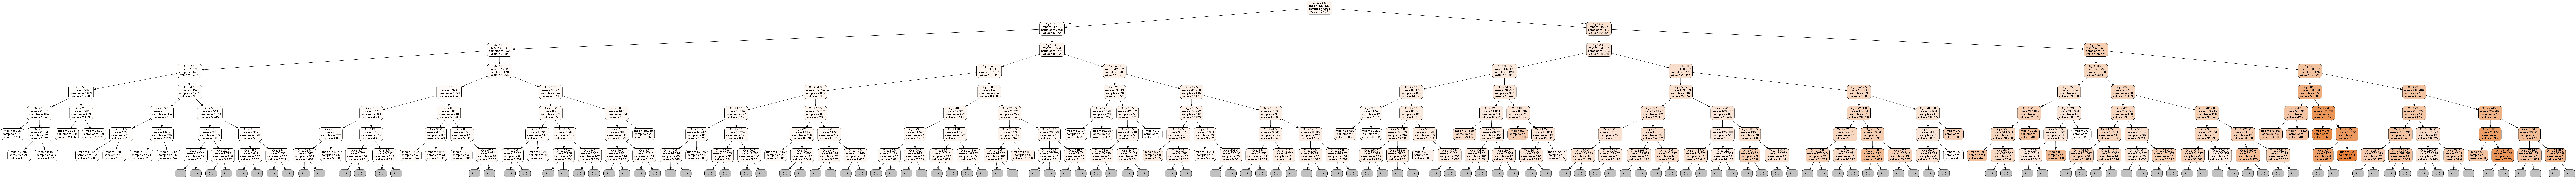

In [398]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()  

export_graphviz(modelDict['dt']['raw'], out_file=dot_data, max_depth = 7,  
                filled=True, rounded=True,
                special_characters=True)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [341]:
X.columns

Index(['DateRank', 'SpG', 'Interaction'], dtype='object')

In [333]:
pd.concat([pd.Series(dt.predict(X)), target], axis = 'columns')

0  Rank
0       1.157895     1
1       1.800000     2
2       1.309192     1
3       1.800000     2
4       2.272727     1
5       2.615385     2
6       3.462963     3
7       2.666667     4
8       3.408163     5
9       1.714976     1
10      2.238806     2
11      2.202128     3
12      1.000000     1
13      2.666667     1
14      3.064103     2
15      3.462963     3
16      2.684685     4
17      3.408163     5
18      2.117647     1
19      1.714976     2
20      2.117647     3
21      7.400000     1
22      9.375000     2
23      8.777778     3
24      7.428571     4
25     10.000000     5
26     10.000000     6
27     11.800000     7
28     10.000000     8
29      9.285714     9
...          ...   ...
10827   2.833333     3
10828   2.684685     4
10829   3.400000     5
10830   1.000000     1
10831   2.776786     1
10832   2.263158     2
10833   2.520000     3
10834   3.073529     4
10835   1.000000     1
10836   1.000000     1
10837   3.400000     1
10838   4.388889     2
10839   3.400000     3
10840   3.400000     4
10841   6.375000     5
10842   6.142857     6
10843   5.400000     7
10844   4.051282     8
10845   6.142857     9
10846   1.000000     1
10847   2.272727     1
10848   3.408163     2
10849   2.684685     3
10850   3.064103     4
10851   2.833333     5
10852   1.157895     1
10853   1.800000     2
10854   1.000000     1
10855   1.000000     1
10856   1.000000     1

[10857 rows x 2 columns]

Need to define baseline, which would be simply guessing in the middle for each s/g

In [350]:
modeldf = df[df['SpG'] != 1]

In [349]:
from sklearn.metrics import mean_squared_error, r2_score
r2_score()


In [361]:
modeldf.head(10)

Rank             Order         Family      Genus        Species  \
0     1  STRUTHIONIFORMES  Struthionidae   Struthio        camelus   
1     2  STRUTHIONIFORMES  Struthionidae   Struthio  molybdophanes   
2     1        RHEIFORMES        Rheidae       Rhea      americana   
3     2        RHEIFORMES        Rheidae       Rhea        pennata   
4     1    APTERYGIFORMES    Apterygidae    Apteryx      australis   
5     2    APTERYGIFORMES    Apterygidae    Apteryx       mantelli   
6     3    APTERYGIFORMES    Apterygidae    Apteryx           rowi   
7     4    APTERYGIFORMES    Apterygidae    Apteryx         owenii   
8     5    APTERYGIFORMES    Apterygidae    Apteryx        haastii   
9     1    CASUARIIFORMES    Casuariidae  Casuarius      casuarius   

  BreedRegion  OrigG  SDate                                       SAuthors  \
0          AF   True   1758                                     [linnaeus]   
1          AF   True   1883                                    [reichenow]   
2          SA  False   1758                                     [linnaeus]   
3          SA   True   1834                                    [d'orbigny]   
4          AU   True   1813                                         [shaw]   
5          AU   True   1852                                     [bartlett]   
6          AU   True   2003  [tennyson, palma, robertson, worthy, gill bj]   
7          AU   True   1847                                        [gould]   
8          AU   True   1872                                        [potts]   
9          AU  False   1758                                     [linnaeus]   

   GDate    GAuthors  DateRank  SpG  
0   1758  [linnaeus]         1    2  
1   1758  [linnaeus]         2    2  
2   1760   [brisson]         1    2  
3   1760   [brisson]         2    2  
4   1813      [shaw]         1    5  
5   1813      [shaw]         3    5  
6   1813      [shaw]         5    5  
7   1813      [shaw]         2    5  
8   1813      [shaw]         4    5  
9   1760   [brisson]         1    3

In [367]:
rawBase.head(10)

0    2.5
1    2.5
2    2.5
3    2.5
4    5.5
5    5.5
6    5.5
7    5.5
8    5.5
9    3.5
Name: SpG, dtype: float64

In [375]:
np.log(3)

1.0986122886681098

In [374]:
rawBase[:10]

0    1.5
1    1.5
2    1.5
3    1.5
4    3.0
5    3.0
6    3.0
7    3.0
8    3.0
9    2.0
Name: SpG, dtype: float64

In [385]:
stdTarget.describe()

count    9955.000000
mean        0.429181
std         0.291273
min         0.000000
25%         0.178571
50%         0.444444
75%         0.666667
max         0.988889
dtype: float64

In [389]:
stdTarget = (modeldf['Rank']-1) / modeldf['SpG']
rawTarget = modeldf['Rank']
logTarget = np.log(modeldf['Rank'])

targetDict = {'std':stdTarget, 'raw': rawTarget, 'log':logTarget}

stdBase = [np.mean(stdTarget) for r in modeldf['Rank']]
rawBase = (modeldf['SpG']+1)/2
logBase = np.log(rawBase)
baselineDict = {'std': stdBase, 'raw':rawBase, 'log':logBase}

myPred = [1 if modeldf.loc[idx,'DateRank'] ==1 else (modeldf.loc[idx,'SpG']+1)/2 for idx in modeldf.index]
logMyPred = np.log(myPred)

tofit = ['DateRank','SpG']#, 'OrigG']
X = modeldf[tofit]
X['Interaction'] = X['DateRank']*X['SpG']

modelDict = {'lm':{}, 'dt':{}}
for t in ['std', 'raw','log']:
    modelDict['lm'][t] = LinearRegression()
    modelDict['dt'][t] = DecisionTreeRegressor()

for mod in modelDict:
    for k in modelDict[mod]:
        target = targetDict[k]
        modelDict[mod][k].fit(X, target)
        preds = modelDict[mod][k].predict(X)
        print(mod,k)
        print('mse', mean_squared_error(target, preds), mean_squared_error(target, baselineDict[k]))
        print('R^2', r2_score(target, preds), r2_score(target, baselineDict[k]),'\n')
print('raw', r2_score(rawTarget, myPred), mean_squared_error(rawTarget, myPred))
print('log', r2_score(logTarget,logMyPred), mean_squared_error(logTarget, logMyPred))

lm std
mse 0.0815027213689 0.0848314700772
R^2 0.03923954996 0.0 

lm raw
mse 51.5198553529 51.676343546
R^2 0.596325804819 0.595099670837 

lm log
mse 0.54246887521 0.532636746066
R^2 0.541237627027 0.549552594214 

dt std
mse 0.0662078665284 0.0848314700772
R^2 0.219536494321 0.0 

dt raw
mse 26.0345658217 51.676343546
R^2 0.796011026564 0.595099670837 

dt log
mse 0.377409800626 0.532636746066
R^2 0.680827004773 0.549552594214 

raw 0.543276611211 58.2903817177
log 0.401941782229 0.707180858365


C:\Users\William\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [394]:
dt.tree_.max_depth

30

In [412]:
1000000000/10000


100000.0

In [409]:
target = df['Rank']
#target = np.log(target)
tofit = ['DateRank','SpG']#, 'OrigG']
X = df[tofit]
X['Interaction'] = X['DateRank']*X['SpG']

lm = LinearRegression()
dt = DecisionTreeRegressor(max_depth= 42)

dt.fit(X, target)
lm.fit(X, target)
print(lm.score(X, target))
print(dt.score(X,target))

0.614069320567
0.804982632546


C:\Users\William\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [344]:
target = df['Rank']
tofit = ['DateRank','SpG']#, 'OrigG']
X = df[tofit]
#X['Interaction'] = X['DateRank']*X['SpG']

lm = LinearRegression()
dt = DecisionTreeRegressor()

dt.fit(X, target)
lm.fit(X, target)
print(lm.score(X, target))
print(dt.score(X,target))

0.613870019452
0.804982632546


In [376]:
with open('./toRet2.pickle', 'rb') as f:
    lst = pickle.load(f)

In [384]:
lst[0][2]

[131,
 113,
 104,
 108,
 131,
 116,
 140,
 120,
 108,
 114,
 137,
 95,
 111,
 137,
 135,
 145,
 123,
 111,
 108,
 112,
 105,
 163,
 134,
 113,
 108,
 126,
 120,
 135,
 112,
 129,
 94,
 107,
 129,
 112,
 101,
 129,
 132,
 132,
 113,
 96,
 116,
 133,
 127,
 157,
 110,
 135,
 110,
 110,
 88,
 101,
 94,
 140,
 117,
 128,
 139,
 119,
 102,
 122,
 148,
 104,
 133,
 125,
 132,
 115,
 112,
 112,
 119,
 131,
 138,
 140,
 104,
 135,
 144,
 123,
 103,
 119,
 117,
 117,
 123,
 117,
 139,
 121,
 156,
 124,
 149,
 125,
 116,
 119,
 121,
 121,
 100,
 96,
 116,
 119,
 141,
 134,
 112,
 113,
 106,
 120,
 95,
 130,
 101,
 106,
 119,
 126,
 119,
 106,
 133,
 124,
 99,
 114,
 130,
 129,
 125,
 117,
 120,
 125,
 122,
 131,
 134,
 126,
 109,
 112,
 127,
 111,
 129,
 114,
 110,
 124,
 108,
 99,
 121,
 99,
 93,
 114,
 99,
 110,
 101,
 124,
 142,
 113,
 113,
 120,
 119,
 132,
 120,
 112,
 121,
 133,
 135,
 95,
 126,
 134,
 120,
 100,
 125,
 107,
 118,
 106,
 114,
 122,
 113,
 117,
 115,
 81,
 92,
 117,
 116,
 

In [329]:
lm.coef_

array([ 0.0756499 ,  0.47987966,  0.08136507, -0.00055005])

In [327]:
target = df['Rank']
tofit = ['DateRank','SpG']
X = df[tofit]
X['Interaction'] = X['DateRank']*X['SpG']

lm = LinearRegression()

lm.fit(X, target)
lm.score(X, target)

C:\Users\William\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


0.61406932056714658

In [320]:
lm.coef_

array([ 0.0493274,  0.4757684])

In [124]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Initial EDA

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [541]:
def plotSpg(data, num):
    df = data[data['SpG']==num]
    row = int(num/3)+1
    for i in range(1,num+1):
        #plt.figure(figsize = (10,8))
        plt.subplot(row,3,i)
        plt.hist(df[df['Rank'] ==i]['DateRank'])
        plt.title('Rank = '+ str(i))
        plt.xlabel('Date Rank')
        #plt.savefigfigfig(str(num) + '.png')
        #plt.ylim(ymax = 130)
        #plt.show()

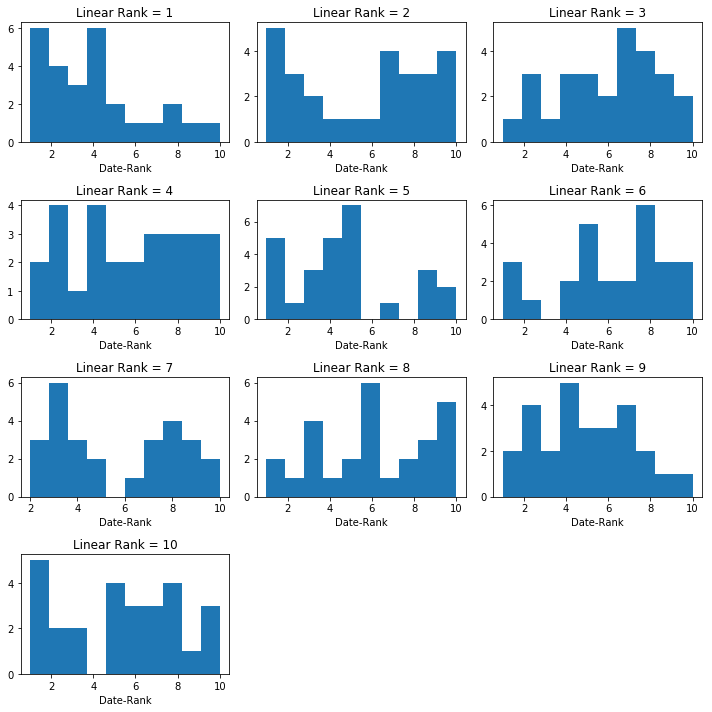

In [544]:
plt.figure(figsize = (10,10))
plotSpg(df, 10)
plt.tight_layout()

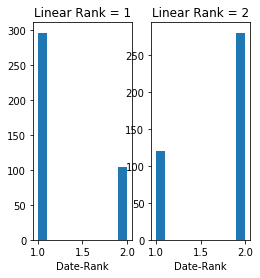

In [41]:
plotSpg(df,2)

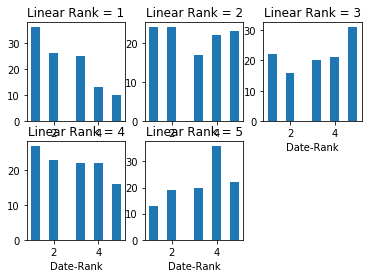

In [31]:
plotSpg(df, 5)

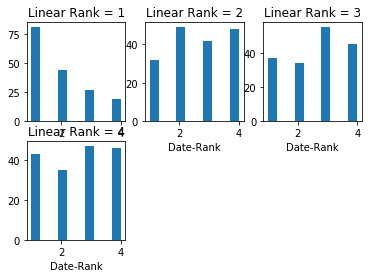

In [32]:
plotSpg(df, 4)

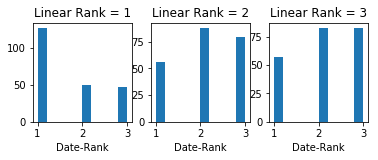

In [33]:
plotSpg(df, 3)

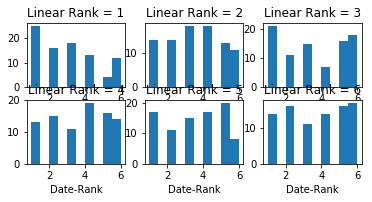

In [34]:
plotSpg(df, 6)

In [316]:
import numpy as np
def simTree(generaNum, generations, split = .1, diffDist = np.random.normal, diffThresh = 1, starterVal = [0]):
    np.random.seed(1738)
    genera = [starterVal for i in range(generaNum)]
    
    for c in range(generations):
        #print(genera)
        for i, g in enumerate(genera):
            toAddInit = []
            toAddFin = []
            for sp in g:
                if np.random.uniform() < split:
                    
                    potentialS = diffDist(sp)
                    #print(potentialS)
                    different = True
                    for s in g:
                        #print(abs(s-potentialS))
                        if abs(s-potentialS) < diffThresh:
                            #print('here')
                            different = False
                            break
                            
                    if different:
                        toAddInit.append(potentialS)
                
            #print(toAddInit)
            if len(toAddInit) >1:
                for idx, pot in enumerate(toAddInit):
                    toAdd = True
                    for idx2 in range(idx, len(toAddInit)):
                        if abs(toAddInit[idx2] - pot) < diffThresh:
                            toAdd = False
                            break
                    if toAdd:
                        toAddFin.append(pot)
            else:
                toAddFin = toAddInit
            if toAddFin != []:
                #print('here2')
                toRep = g.copy()
                toRep.extend(toAddFin)
                genera[i] = toRep
    
    return genera

In [321]:
def simTree2(generaNum, generations, split = .1, diffDist = np.random.normal, diffThresh = 1, starterVal = [0]):
    np.random.seed(1738)
    genera = [starterVal for i in range(generaNum)]
    
    for c in range(generations):
        #print(genera)
        for i, g in enumerate(genera):
            toAddInit = []
            toAddFin = []
            for sp in g:
                if np.random.uniform() < split:
                    
                    potentialS = diffDist(sp)
                    toAddInit.append(potentialS)
                
            toAddFin = toAddInit
            if toAddFin != []:
                #print('here2')
                toRep = g.copy()
                toRep.extend(toAddFin)
                genera[i] = toRep
    
    return genera

In [322]:
%%time
st2 = simTree2(2000,100000, split = .0001, diffThresh = 2)
st2 = [len(e) for e in st2]
plt.scatter(pd.Series(st2).value_counts().index, pd.Series(st2).value_counts().values)

KeyboardInterrupt: 

In [323]:
cts['SpAuthored'].value_counts()

1      444
2      126
0       85
3       72
4       50
5       31
6       20
8       20
7       17
9       12
12      11
11      11
10       8
13       8
15       8
17       8
19       6
14       5
32       4
20       4
26       4
24       3
62       3
83       3
28       3
47       3
21       3
18       3
16       3
23       2
      ... 
203      1
230      1
234      1
242      1
365      1
369      1
399      1
417      1
114      1
112      1
109      1
99       1
465      1
53       1
56       1
57       1
59       1
60       1
65       1
69       1
72       1
73       1
77       1
85       1
86       1
89       1
93       1
94       1
97       1
51       1
Name: SpAuthored, Length: 93, dtype: int64

Wall time: 5min 30s


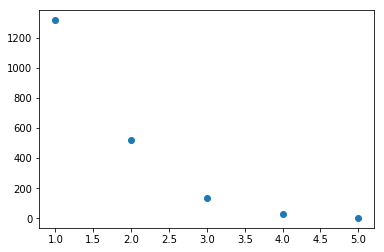

In [320]:
%%time
st2 = simTree(2000,100000, split = .0001, diffThresh = 2)
st2 = [len(e) for e in st2]
plt.scatter(pd.Series(st2).value_counts().index, pd.Series(st2).value_counts().values)

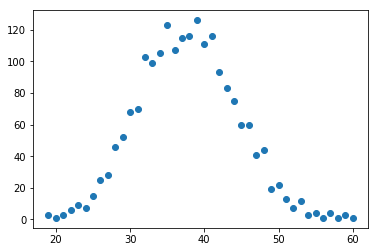

In [318]:
plt.scatter(pd.Series(st2).value_counts().index, pd.Series(st2).value_counts().values)

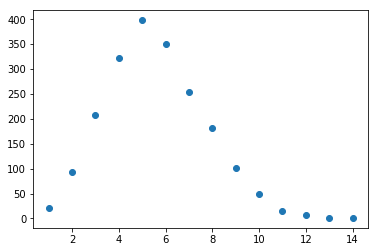

In [309]:
plt.scatter(pd.Series(st).value_counts().index, pd.Series(st).value_counts().values)

In [281]:
spParams =np.logspace(-1,-10)
diffTParam = np.linspace(.5,2.5)

In [285]:
import pickle

spParams =np.logspace(-1,-10)
diffTParam = np.linspace(.5,2.5)
toRet = []

for sp in spParams:
    for dtP in diffTParam:
        print(dtP, sp)
        st = simTree(2000, 1000, split = sp, diffThresh= dtP)
        toRet.append((sp, dtP, [len(e) for e in st]))

with open('toRet.pickle','wb') as f:
    pickle.dump(toRet,f, protocol = 0)

1 0.01
1.5 0.01
2 0.01
1 0.001
1.5 0.001
2 0.001
1 0.0001
1.5 0.0001
2 0.0001
1 1e-05
1.5 1e-05
2 1e-05
Wall time: 1min 28s


### Next Steps

It does look like there is some pattern to the rank-order an description date of the various taxa. The next thing to do will be to define and create metrics to more fully describe what those patterns are.  

Also, next it will be important to start to standardize and investigate the distriution of authorship.

split on space

In [151]:
for idx in df.index:
    au = df.loc[idx,'GAuthors']
    if au.count(' et al')>0:
        print(idx)
    #try:
     #   z = au.split(',')[1]
    #except:
    #    print(idx)

1150
2587
4552
4553
4554
4555
4958
4959
4960
4961
4962
4963
5104
5105
5703
8125
8126
8127
8128
8998
8999
10285


In [45]:
for idx in df.index:
    try:
        df.loc[idx,'SAuth'].split(',')[1]
    except:
        pass
        #print(idx)

# Deprecated

In [20]:
df2 = pd.DataFrame(df.groupby(['SpG','Rank', 'DateRank',])['Species'].count())

In [676]:
df2.head()

Species
SpG Rank DateRank         
1   1    1             902
2   1    1             296
         2             104
    2    1             120
         2             280

In [9]:
# Requires Raw Data

def authorCounts(data):
    SpAuths = data['SAuthors']
    GeAuths = data.groupby(['Genus'])['GAuthors'].unique()
    SpAuths = [authorSplit(e) for e in SpAuths]
    GeAuths = [authorSplit(e[0]) for e in GeAuths]
    
    def unlistAuthors(AList):
        ulAuths = []
        for lst in AList:
            for n in lst:
                ulAuths.append(n)
        ulAuths = pd.Series(ulAuths)
        ulAuths = ulAuths.value_counts()
        
        return ulAuths
    
    SpAuths = unlistAuthors(SpAuths)
    SpAuths.name = 'SpAuthored'
    GeAuths = unlistAuthors(GeAuths)
    GeAuths.name = 'GenAuthored'
    toRet = pd.concat([GeAuths, SpAuths], axis = 'columns')
    toRet.fillna(0, inplace  = True)
    for c in toRet:
        toRet[c] = toRet[c].astype(int)
    
    return toRet

In [255]:
def makeSpeciesRankDateTablesOLD(data):
    
    data = pd.DataFrame(data.groupby(['SpG','Rank', 'DateRank',])['Species'].count())
    
    tables = {}
    
    currentSPG = 0
    currentRank = 0
    prevDR = 0
    full = True
    
    for idx in data.index:
        
        # index in the format (species/genus, Rank, Date Rank)
        spg = idx[0]
        
        if spg >10:
            break
            
        rank = idx[1]
        dRank = idx[2]
        
        sp = data.loc[idx, 'Species']
        
        # If the s/G changes, create new list, reset counter variables
        if spg != currentSPG:
            if not full:
                while len(tables[currentSPG][currentRank]) < currentSPG:
                    tables[currentSPG][currentRank].append(0)
                    
            tables[spg] = {}
            currentSPG = spg
            tables[spg][rank] = []
            currentRank = 1
            prevDR = 0
            full = False
        
        # If rank changes, create new list, reset dateRank counter
        if rank != currentRank:
            if not full:
                while len(tables[currentSPG][currentRank]) < currentSPG:
                    tables[currentSPG][currentRank].append(0)
                    
            tables[spg][rank] = []
            currentRank = rank
            prevDR = 0
        
        # Check to see that current date rank is only one greater than previous
        # DateRank, if not, one was skipped, in which case zeros need to be added
        if prevDR +1 != dRank:
            for i in range(dRank-prevDR-1):
                tables[spg][rank].append(0)
        
        #append number of species
        tables[spg][rank].append(sp)
        full = len(tables[spg][rank]) == currentSPG
        prevDR = dRank
    if not full:
        while len(tables[currentSPG][currentRank])<currentSPG:
            tables[currentSPG][currentRank].append(0)
    return tables    

In [243]:
SA = raw['SAuthors']
SAsp = pd.Series([authorSplit(e) for e in SA])
GA = raw['GAuthors']
GAsp = pd.Series([authorSplit(e) for e in GA])

In [244]:
sm = ['de','da','sr','la','le','jr','du','do','zu']
bef = ['zu','du', 'la'] #Du Bus de Gisignies, La Touche, Da Silva Maia
med = ['du', 'la'] # Barboza du Bocage, de la Llave, 
unk = ['do','le']
post = ['jr','sr']
test = ['da']

In [246]:
probs = []
for idx in GAsp.index:
    try:
        for n in GAsp[idx]:
            if n in sm:
                probs.append(idx)
    except:
        print('whoops', idx)
Ghard = list(raw.loc[probs,'GAuthors'].unique())
Ghard

['Le Maout',
 'Raposo do Amaral EtAl',
 'Du Bus de Gisignies',
 'zu Wied-Neuwied',
 'De Roo',
 'de la Llave',
 'De Vis',
 'de Sélys-Longchamps',
 'de Filippi']

In [247]:
for n in Ghard:
    if n not in hard:
        hard.append(n)

In [255]:
hard

['zu Wied-Neuwied',
 'Meyer de Schauensee',
 'Barboza du Bocage',
 'Meyer de Schauensee',
 'de Sélys-Longchamps',
 'Du Bus de Gisignies',
 'Gurney Sr',
 'de Sparre',
 'Gurney Jr',
 'Xántus de Vésey',
 'Da Silva Maia',
 'de la Llave',
 'de Filippi',
 'Phelps Jr',
 'Cardoso da Silva Novaes',
 'Wetmore Phelps Jr',
 'Giraud Jr',
 'De Vis',
 'De Roo',
 'La Touche',
 'Marshall JT Jr',
 'de Tarragon',
 'Phelps Jr',
 'Le Maout',
 'Raposo do Amaral']

In [46]:
speciesTree = {}
for o in soup.find_all('order'):
    oname = o.find('latin_name').text
    #print(oname)
    speciesTree[oname] = {}
    for f in o.find_all('family'):
        fname = f.find('latin_name').text
        #print(fname)
        speciesTree[oname][fname]= {}
        for g in f.find_all('genus'):
            gname = g.find('latin_name').text
            #print(gname)
            speciesTree[oname][fname][gname] = {'GAuthority': g.find('authority').text}
            for s in g.find_all('species'):
                sname = s.find('latin_name').text
                #print(sname)
                #print(s.find('authority').text)
                speciesTree[oname][fname][gname][sname] = {'SAuthourity': s.find('authority').text,
                                                           'Breeding' : s.find('breeding_regions').text}

In [103]:
df2 = pd.DataFrame(df.groupby(['SpG','Rank', 'DateRank',])['Species'].count())

In [104]:
tables = {}
currentSPG = 0
currentRank = 0
prevDR = 0
for idx in df2.index:
    if idx[0] >10:
        break
        
    spg = idx[0]
    rank = idx[1]
    dRank = idx[2]
    sp = df2.loc[idx, 'Species']
    
    if spg != currentSPG:
        tables[spg] = {}
        currentSPG = spg
        tables[spg][rank] = []
        currentRank = 1
        prevDR = 0
        
    if rank != currentRank: 
        tables[spg][rank] = []
        currentRank = rank
        prevDR = 0
    
    if prevDR +1 != dRank:
        for i in range(dRank-prevDR-1):
            
            tables[spg][rank].append(0)
    
    tables[spg][rank].append(sp)
    prevDR = dRank

    tables    

In [105]:
tables

{1: {1: [902]},
 2: {1: [296, 104], 2: [120, 280]},
 3: {1: [127, 49, 47], 2: [56, 88, 79], 3: [57, 83, 83]},
 4: {1: [81, 44, 27, 19],
  2: [32, 49, 42, 48],
  3: [37, 34, 55, 45],
  4: [43, 35, 47, 46]},
 5: {1: [36, 26, 25, 13, 10],
  2: [24, 24, 17, 22, 23],
  3: [22, 16, 20, 21, 31],
  4: [27, 23, 22, 22, 16],
  5: [13, 19, 20, 36, 22]},
 6: {1: [25, 16, 18, 13, 4, 12],
  2: [14, 14, 18, 18, 13, 11],
  3: [21, 11, 15, 7, 16, 18],
  4: [13, 15, 11, 19, 16, 14],
  5: [17, 11, 15, 17, 20, 8],
  6: [14, 16, 11, 14, 16, 17]},
 7: {1: [19, 6, 8, 5, 5, 5, 8],
  2: [6, 7, 9, 6, 8, 7, 13],
  3: [6, 8, 8, 11, 11, 7, 5],
  4: [6, 9, 6, 6, 9, 9, 11],
  5: [13, 9, 4, 8, 6, 10, 6],
  6: [12, 8, 7, 10, 8, 3, 8],
  7: [7, 4, 10, 8, 9, 14, 4]},
 8: {1: [14, 7, 5, 5, 5, 4, 3, 1],
  2: [8, 5, 7, 4, 9, 7, 2, 2],
  3: [4, 5, 9, 3, 3, 5, 7, 8],
  4: [8, 2, 2, 8, 7, 4, 6, 7],
  5: [3, 2, 5, 6, 7, 6, 6, 9],
  6: [7, 7, 5, 5, 6, 3, 6, 5],
  7: [6, 4, 7, 6, 3, 7, 5, 6],
  8: [6, 7, 4, 5, 4, 4, 8, 6]},
 9: 

     1
1  902
902
902.0
     1    2
1  296  120
2  104  280
800
400.0
     1   2   3
1  127  56  57
2   49  88  83
3   47  79  83
669
223.0
    1   2   3   4
1  81  32  37  43
2  44  49  34  35
3  27  42  55  47
4  19  48  45  46
684
171.0
    1   2   3   4   5
1  36  24  22  27  13
2  26  24  16  23  19
3  25  17  20  22  20
4  13  22  21  22  36
5  10  23  31  16  22
550
110.0
    1   2   3   4   5   6
1  25  14  21  13  17  14
2  16  14  11  15  11  16
3  18  18  15  11  15  11
4  13  18   7  19  17  14
5   4  13  16  16  20  16
6  12  11  18  14   8  17
528
88.0
    1   2   3   4   5   6   7
1  19   6   6   6  13  12   7
2   6   7   8   9   9   8   4
3   8   9   8   6   4   7  10
4   5   6  11   6   8  10   8
5   5   8  11   9   6   8   9
6   5   7   7   9  10   3  14
7   8  13   5  11   6   8   4
392
56.0
    1  2  3  4  5  6  7  8
1  14  8  4  8  3  7  6  6
2   7  5  5  2  2  7  4  7
3   5  7  9  2  5  5  7  4
4   5  4  3  8  6  5  6  5
5   5  9  3  7  7  6  3  4
6   4  7  5  4  

Text(0.009,0,'Proportion\n of\n species')

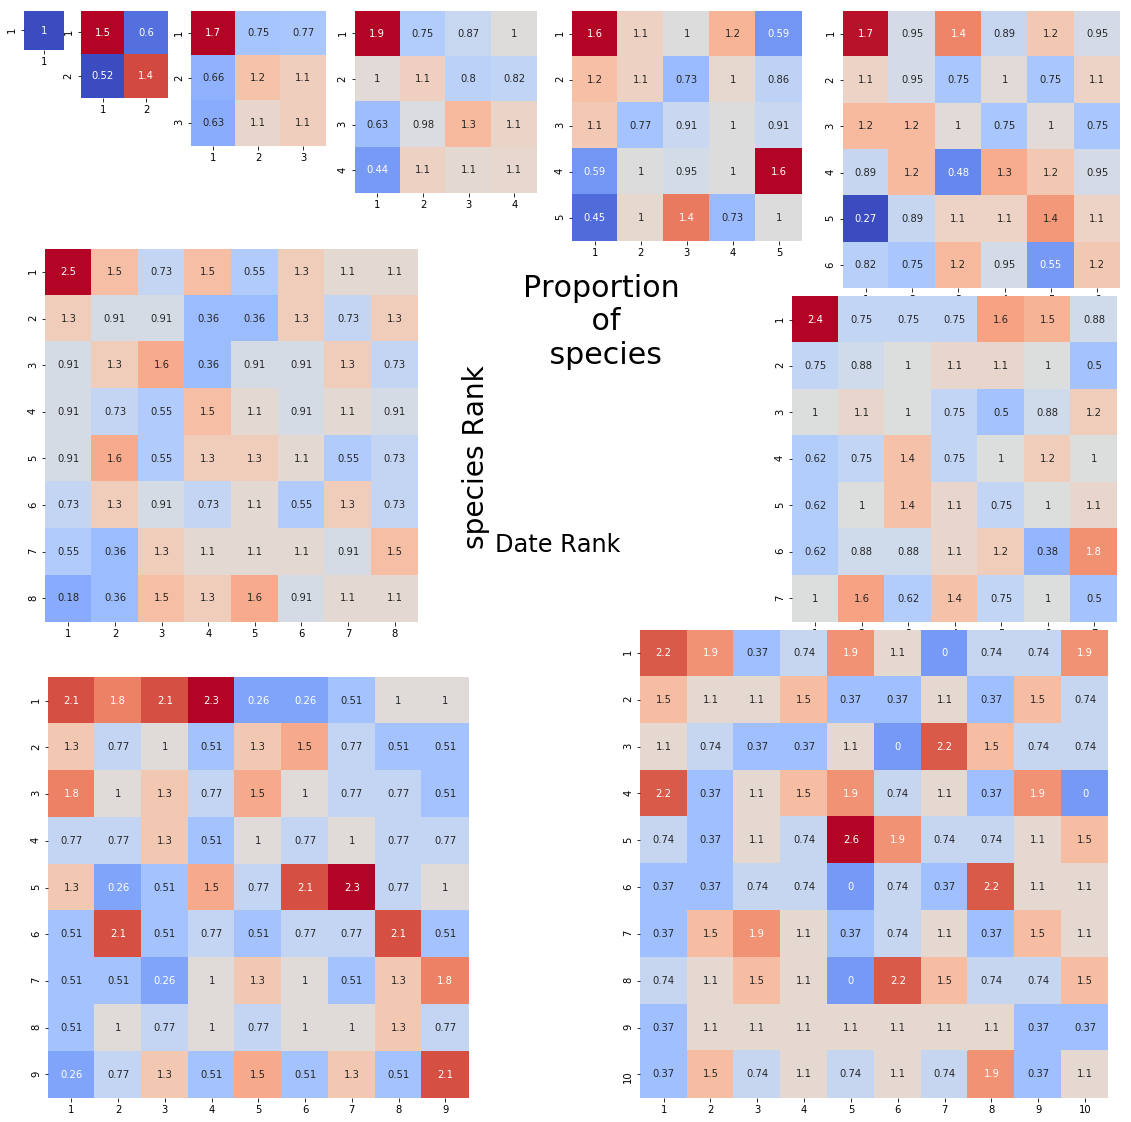

In [115]:
locs = {1:(1,1),2:(1,2),3:(1,4),4:(1,7),5:(1,11),6:(1,16),7:(7,15),8:(6,1),9:(15,1),10:(14,12)}
plt.figure(figsize = (20,20))
i = 0
ret = {}
for k in tables:
    i+=1
    
    temp = pd.DataFrame(tables[k])
    temp.index = range(1,len(temp)+1)
    print(temp)
    spg = len(temp)
    obs = 0
    for c in temp:
        obs += temp[c].sum()
    Ginspg =obs/spg
    print(obs)
    print(Ginspg)
    
    for c in temp.index:
        
    for c in temp:
        temp[c] = [e/temp[c].sum()/(1/len(temp)) for e in temp[c]]
    where = locs[i]
    pltNum = where[0]*21+where[1]
    
    plt.subplot2grid((23,21),(where[0]-1, where[1]-1),colspan = i, rowspan = i)
    sns.heatmap(temp, annot = True, cmap = 'coolwarm', center = 1,square = True, cbar = False)
plt.subplot2grid((23,21),(5,8), colspan = 5, rowspan = 5)

plt.xlabel('hi')
plt.ylabel('no')
plt.axis('equal')
plt.axis('off')
plt.text(-0.05,-0.01,'species Rank', rotation = 'vertical', fontsize = 28)#, horizontalalignment = 'right')
plt.text(-0.036,-0.08,'Date Rank', rotation = 'horizontal', fontsize = 24)#, horizontalalignment = 'left')
plt.text(0.009,0.00,'Proportion\n of\n species', fontsize = 30, horizontalalignment = 'center')
#plt.title('yup')

     1
1  902
902
902.0
     1    2
1  296  120
2  104  280
800
200.0
     1   2   3
1  127  56  57
2   49  88  83
3   47  79  83
669
74.33333333333333
    1   2   3   4
1  81  32  37  43
2  44  49  34  35
3  27  42  55  47
4  19  48  45  46
684
42.75
    1   2   3   4   5
1  36  24  22  27  13
2  26  24  16  23  19
3  25  17  20  22  20
4  13  22  21  22  36
5  10  23  31  16  22
550
22.0
    1   2   3   4   5   6
1  25  14  21  13  17  14
2  16  14  11  15  11  16
3  18  18  15  11  15  11
4  13  18   7  19  17  14
5   4  13  16  16  20  16
6  12  11  18  14   8  17
528
14.666666666666666
    1   2   3   4   5   6   7
1  19   6   6   6  13  12   7
2   6   7   8   9   9   8   4
3   8   9   8   6   4   7  10
4   5   6  11   6   8  10   8
5   5   8  11   9   6   8   9
6   5   7   7   9  10   3  14
7   8  13   5  11   6   8   4
392
8.0
    1  2  3  4  5  6  7  8
1  14  8  4  8  3  7  6  6
2   7  5  5  2  2  7  4  7
3   5  7  9  2  5  5  7  4
4   5  4  3  8  6  5  6  5
5   5  9  3  7  7  

Text(0.009,0,'Proportion\n of\n species')

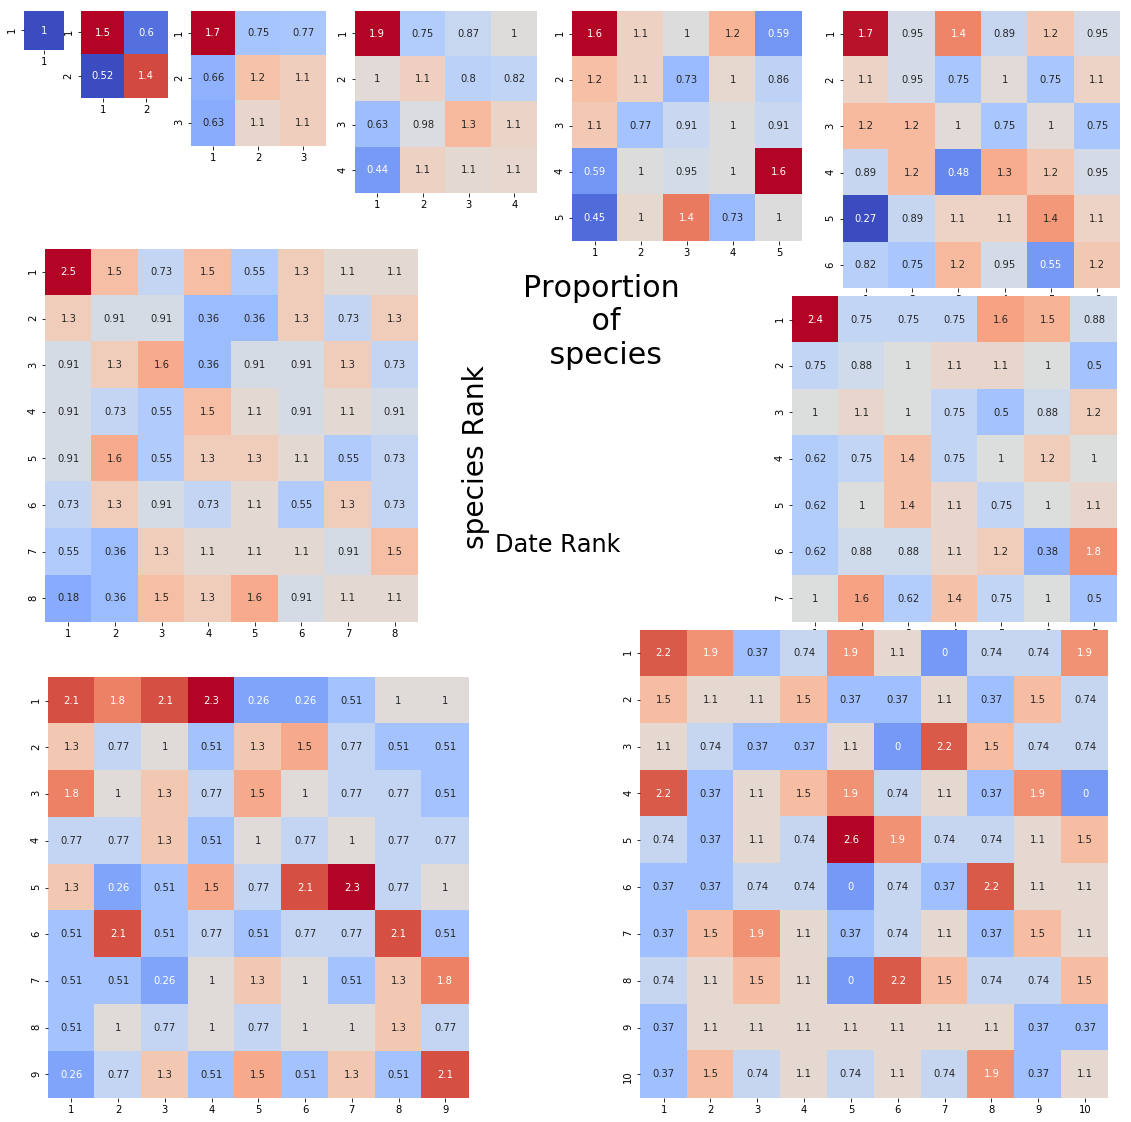

In [112]:
locs = {1:(1,1),2:(1,2),3:(1,4),4:(1,7),5:(1,11),6:(1,16),7:(7,15),8:(6,1),9:(15,1),10:(14,12)}
plt.figure(figsize = (20,20))
i = 0
for k in tables:
    i+=1
    
    temp = pd.DataFrame(tables[k])
    temp.index = range(1,len(temp)+1)
    print(temp)
    spg = len(temp)
    obs = 0
    for c in temp:
        obs += temp[c].sum()
    Ginspg =obs/(spg**2)
    print(obs)
    print(Ginspg)
    for c in temp:
        temp[c] = [e/temp[c].sum()/(1/len(temp)) for e in temp[c]]
    where = locs[i]
    pltNum = where[0]*21+where[1]
    
    plt.subplot2grid((23,21),(where[0]-1, where[1]-1),colspan = i, rowspan = i)
    sns.heatmap(temp, annot = True, cmap = 'coolwarm', center = 1,square = True, cbar = False)
plt.subplot2grid((23,21),(5,8), colspan = 5, rowspan = 5)

plt.xlabel('hi')
plt.ylabel('no')
plt.axis('equal')
plt.axis('off')
plt.text(-0.05,-0.01,'species Rank', rotation = 'vertical', fontsize = 28)#, horizontalalignment = 'right')
plt.text(-0.036,-0.08,'Date Rank', rotation = 'horizontal', fontsize = 24)#, horizontalalignment = 'left')
plt.text(0.009,0.00,'Proportion\n of\n species', fontsize = 30, horizontalalignment = 'center')
#plt.title('yup')